# TODO: 
- Tutte le task: fare train con 30 seeds (?) e 20 epoche (?) e poi fare commenti risultati
- ~~Tutte le task: gestire val loss?~~
- ~~Tutte le task: impostare salvataggio dei risultati (array numpy -> pd DataFrame -> file excel) e grafici ~~
- ~~Task 3: rapporti alpha e beta per mixed da capire anche in base al punto precedente -> facciamo 1 e 1~~
- Task 4: gamma partire con 1.0 ma eventualmente da fare un po' di esperimenti / tuning 
- Task 4: fare solo con dati migliori (alpha e beta di conseguenza)
- Task 4: provare a implementare anche strada con log e exp anzichè aggiungere nuova loss 
- Task 5: aggiungere lagrangiano a modello migliore 
- Task 5: peso dinamico a beta (eventualmente gamma se usiamo modello task 4), alpha statico a 1
- Task 5: fare solo con dati migliori

- PW da impostare dopo aver discusso progetto

In [50]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow as tf
import random
#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import backend as k
from keras.callbacks import CSVLogger

import pandas as pd
from tabulate import tabulate

stop = 1400
epochs = 5
batch_size = 32
num_seeds = 2
excel_file_path = 'results.xlsx'



## Data Loading and Preparation

### Data loading

In [51]:
# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)
# Identify input columns
dt_in = list(data.columns[3:-1])

### Data inspection


- *src* is the train surce 
- *machine* is the number associated to a single machine
- *p* are the controlled parameters
- *s* are the sensors
- *rul* is the remaining useful life, namely the label 

In [52]:
data.head()

src  machine  cycle      p1      p2     p3      s1      s2  \
0  train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1  train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2  train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3  train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4  train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   

        s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0  1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  rul  
0  39.06  23.4190  191  
1  39.00  23.4236  190  
2  38.95  23.3442  189  
3  38.88  23.3739  188  
4  38.90  23.4044  187  

[5 rows x 28 columns]

Example of machine 1: the rul value goes from 191 to 0 decreasing monotonically

In [53]:
#print the data with 'machine' = 1
data[data['machine'] == 1].head(len(data[data['machine'] == 1]))

src  machine  cycle      p1      p2     p3      s1      s2  \
0    train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1    train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2    train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3    train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4    train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   
..           ...      ...    ...     ...     ...    ...     ...     ...   
187  train_FD001        1    188 -0.0067  0.0003  100.0  518.67  643.75   
188  train_FD001        1    189 -0.0006  0.0002  100.0  518.67  644.18   
189  train_FD001        1    190 -0.0027  0.0001  100.0  518.67  643.64   
190  train_FD001        1    191 -0.0000 -0.0004  100.0  518.67  643.34   
191  train_FD001        1    192  0.0009 -0.0000  100.0  518.67  643.54   

          s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0    1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1    1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2    1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3    1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4    1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
..       ...      ...  ...      ...      ...     ...   ...  ...   ...    ...   
187  1602.38  1422.78  ...  2388.23  8117.69  8.5207  0.03  396  2388  100.0   
188  1596.17  1428.01  ...  2388.33  8117.51  8.5183  0.03  395  2388  100.0   
189  1599.22  1425.95  ...  2388.35  8112.58  8.5223  0.03  398  2388  100.0   
190  1602.36  1425.77  ...  2388.30  8114.61  8.5174  0.03  394  2388  100.0   
191  1601.41  1427.20  ...  2388.32  8110.93  8.5113  0.03  396  2388  100.0   

       s20      s21  rul  
0    39.06  23.4190  191  
1    39.00  23.4236  190  
2    38.95  23.3442  189  
3    38.88  23.3739  188  
4    38.90  23.4044  187  
..     ...      ...  ...  
187  38.51  22.9588    4  
188  38.48  23.1127    3  
189  38.49  23.0675    2  
190  38.45  23.1295    1  
191  38.48  22.9649    0  

[192 rows x 28 columns]

We will plot a histogram showing the distribution of max rul values for each machine

<Axes: >

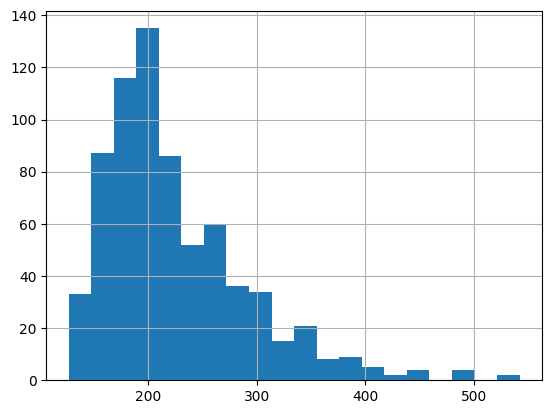

In [54]:
#define a histogram with value of rul for each machine where cycle=1 and src='FD001'
data[data['cycle'] == 1].groupby(['machine']).max()['rul'].hist(bins=20)


In [55]:
#standardize data
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

In [56]:
data_by_src = cst.split_by_field(data_sv, field='src')

We inspect data by plotting heatmaps. We consider only data conatined in train_FD004, which has 6 operating conditions and 2 fault modes

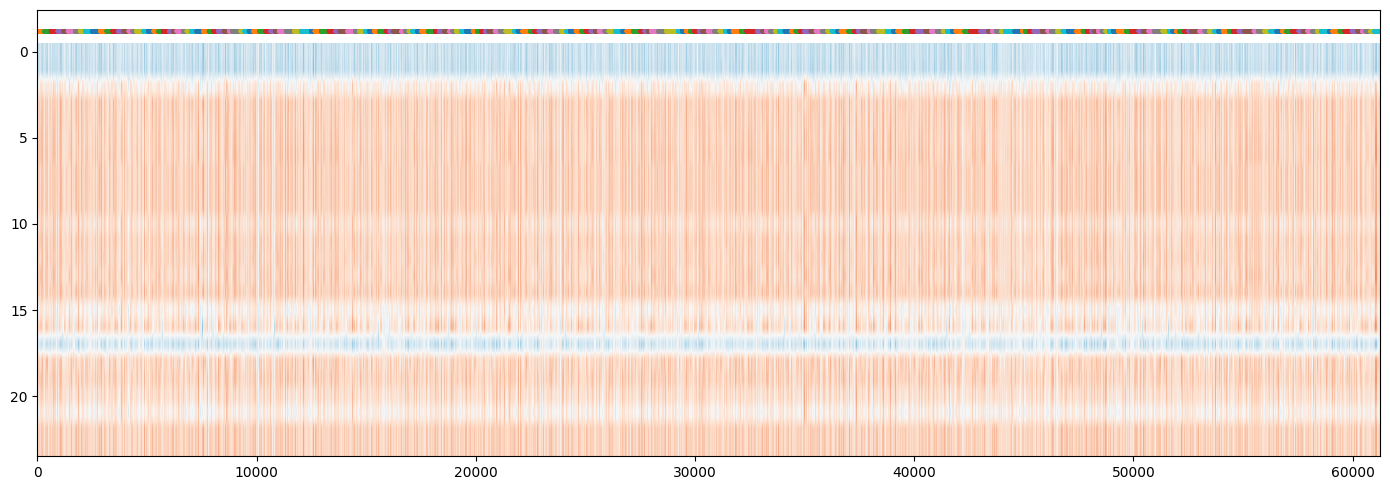

In [57]:
data_sv = data_by_src["train_FD004"]
cst.plot_dataframe(data_sv[dt_in], labels=data_sv['machine'], figsize=figsize)

There is a high varibaility in the plotted series, which is the result of multiple operating conditions

We will then inspect in detail a column providing information on a given sensor, to see if there is any claer trend in the data.

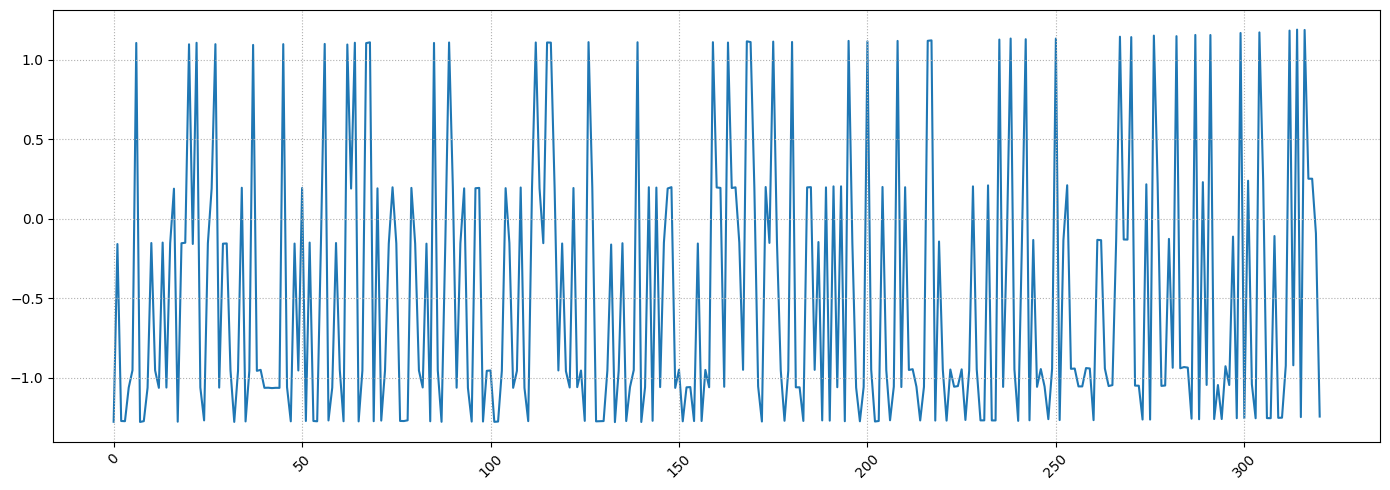

In [9]:
tmp = data_sv[data_sv['machine'] == data_sv['machine'].iloc[0]]
cst.plot_series(tmp['s7'], figsize=figsize)

There is a weak trend tied to component wear, and it is mainly covered by wide oscillations. 

In [58]:
#we use just dataset 4
dt = data_by_src["train_FD004"]

In [12]:
dt.head()

src  machine  cycle        p1        p2        p3        s1  \
0  train_FD004      461      1  1.500057  1.168664  0.345954 -1.342550   
1  train_FD004      461      2  0.168806  0.788709  0.345954  0.175840   
2  train_FD004      461      3  1.499991  1.171110  0.345954 -1.342550   
3  train_FD004      461      4  1.499761  1.168664  0.345954 -1.342550   
4  train_FD004      461      5  0.471584  0.572641 -2.890543 -0.765963   

         s2        s3        s4  ...       s13       s14       s15       s16  \
0 -1.122474 -1.045952 -1.086033  ...  0.344929 -0.175148  0.370889 -1.037783   
1  0.205021  0.089480 -0.172094  ...  0.342590 -0.531124  0.181688 -1.037783   
2 -1.139659 -1.048575 -1.055806  ...  0.344749 -0.276979  0.460301 -1.037783   
3 -1.145544 -1.064484 -1.048616  ...  0.345198 -0.160016  0.375413 -1.037783   
4 -1.442165 -1.792301 -1.668131  ... -2.892626 -2.767824  2.370806 -1.037783   

        s17       s18       s19       s20       s21  rul  
0 -0.989600 -0.433322  0.345954 -1.310594 -1.311278  320  
1  0.009709  0.352571  0.345954 -0.134518 -0.129792  319  
2 -1.021836 -0.433322  0.345954 -1.322569 -1.303537  318  
3 -1.054071 -0.433322  0.345954 -1.317437 -1.304065  317  
4 -1.795494 -2.517341 -2.890543 -1.018927 -0.982214  316  

[5 rows x 28 columns]

## **Project**

**We will run multiple experiments on our data to analyse the effect of domain knowledge injection via multiple approaches.**

- In the first 3 tasks we will experiment with different ratios and combinations of supervised and unsupervised data.
- In task 4 we will use a static regularizer to inject domain knowledge (RUL>0). 
- In task 5 we will use a lagrangian approach to dynamically maximize the weight of the regularizer.

For the first 3 tasks we use the following training configuration, where we will change parameters according to the task addressed.

In [67]:
def train_model(train_data, val_data, test_data, columns, maxrul, alpha, beta, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstRULRegressor(input_shape=len(columns), alpha=alpha, beta=beta, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(nn.predict(test_data[columns]).ravel()*maxrul)
    return history, pred

The following function is used to train the model for task 4.

In [132]:
def train_task4(train_data, val_data, test_data, columns, maxrul, alpha, beta, gamma, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstPosRULRegressor(len(columns), alpha=alpha, beta=beta, gamma=gamma, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(nn.predict(test_data[columns]).ravel()*maxrul)
    return history, pred
    

Function *train_task5* is used to train the last task of our project.

In [122]:
def train_task5(train_data, val_data, test_data, columns, maxrul, alpha, beta, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstRULRegressorWithLagrangian(input_shape=len(columns), alpha=alpha, beta=beta, maxrul=maxrul, hidden=[32, 32]) 
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(nn.predict(test_data[columns]).ravel()*maxrul)
    return history, pred

### **Task 1**: train the model with only supervised data. We will experiment with different ratios of supervised data. 


In general, we expect that using higher ratios of supervised data will ensure better performances. However, if the model is too simple, it may incur in overfitting. 
- We expect that all the models trained with supervised data are the ones performing better. 
- Moreover, we expect that they learn the decreasing trend and also to predict the failure in an accurate way.
- We foresee that using 100% of supervised data will ensure the best results, however we do not expect that the differences in performances won't be as significant as those in the models with both supervised and unsupervised data. 

#### 1.1 100% of supervised data used for training

In [63]:
trs, vs, ts = cst.split_machines(dt, 0.75, 0)

Num. machines: 149 (supervised), 37 (validation), 63 (test)


In [65]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs, vs, ts, dt_in)

We train the model with different seeds

In [69]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-1.log')

Epoch 1/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0214 - mse: 0.0214 - cst: 0.0075 - val_loss: 0.0170 - val_mse: 0.0170 - val_cst: 0.0042
Epoch 2/5
1232/1232 [==============================] - 3s 3ms/step - loss: 0.0149 - mse: 0.0149 - cst: 0.0041 - val_loss: 0.0174 - val_mse: 0.0174 - val_cst: 0.0035
Epoch 3/5
1232/1232 [==============================] - 4s 4ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0040 - val_loss: 0.0156 - val_mse: 0.0156 - val_cst: 0.0054
Epoch 4/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0144 - mse: 0.0144 - cst: 0.0037 - val_loss: 0.0156 - val_mse: 0.0156 - val_cst: 0.0045
Epoch 5/5
496/496 [==============================] - 0s 381us/step
Epoch 1/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0217 - mse: 0.0217 - cst: 0.0060 - val_loss: 0.0155 - val_mse: 0.0155 - val_cst: 0.0028
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0172 - mse: 0.0172 - cst: 0.004

Train history visualization for the first seed

In [71]:
history = pd.read_csv('history/training-1-1.log')
figsize=(14, 5)

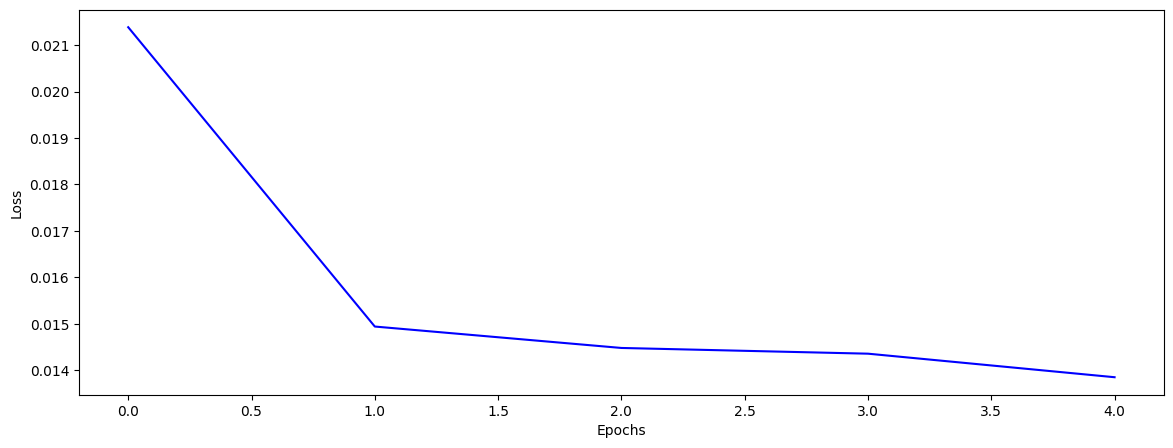

In [72]:
# plot history of the last model
plt.figure(figsize=figsize)
plt.plot(history[:epochs]['loss'], color='blue') # seleziona primo seed
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

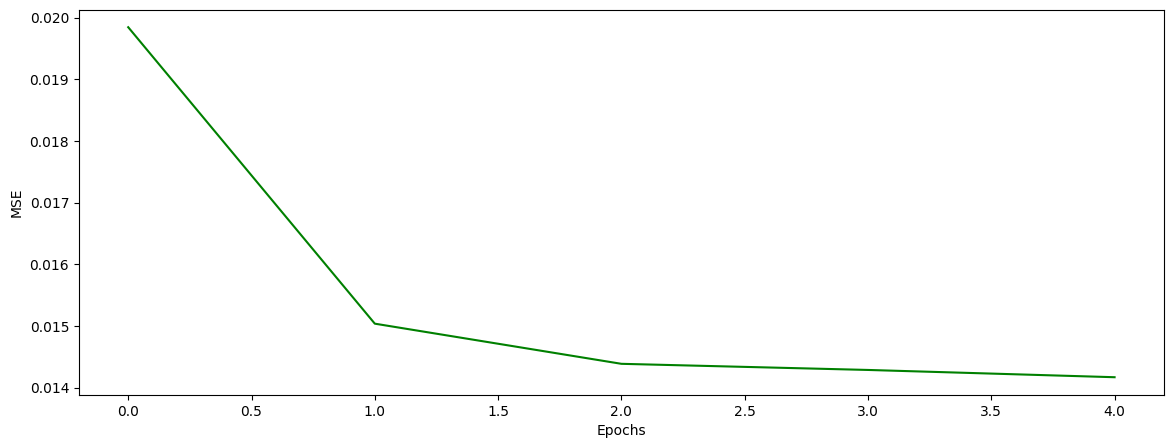

In [18]:
# plot mse of the last model
plt.figure(figsize=figsize)
plt.plot(history[:epochs]['mse'], color='green')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

Evaluation on the test set

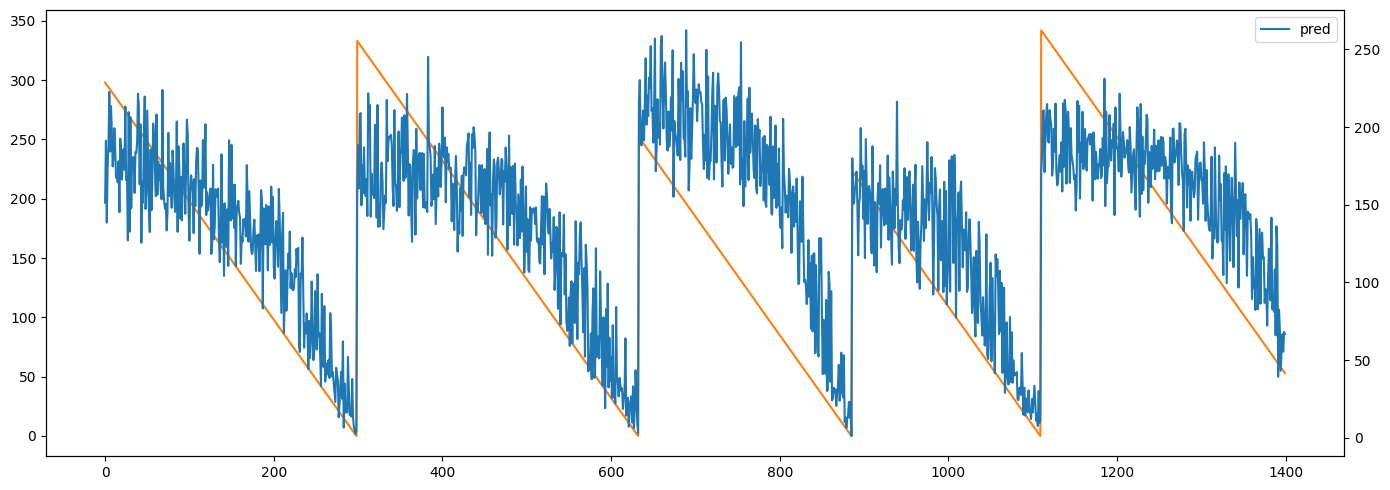

In [73]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [75]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0129
Standard Deviation of MSE: 0.0004


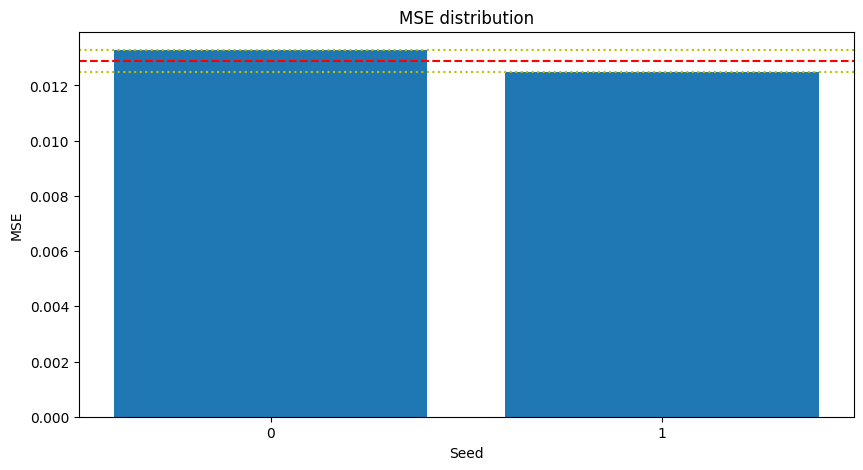

In [76]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [77]:
cst.save_results_to_excel("Task 1.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [78]:
results_task1_1 = pd.read_excel(excel_file_path)
results_task1_1.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1      0.012889     0.000393      0.013282      0.012496     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [79]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-1.xlsx')

In [80]:
pd.read_excel('./predictions/predictions-1-1.xlsx').head(10)

Seed_0      Seed_1  rul
0  151.411194  174.130142  298
1  191.288834  200.025085  297
2  138.489807  166.466583  296
3  174.445343  203.896469  295
4  187.965225  198.307907  294
5  222.636551  217.437576  293
6  184.302094  177.034012  292
7  213.526932  179.867188  291
8  197.002838  176.416641  290
9  174.694763  165.186630  289

#### 1.2 75% of supervised data used for training

In [81]:
trs_2 = cst.split_data(ts, trs=trs, trs_ratio=0.75)

Num. samples: 27559 (supervised), 15864 (test)


In [82]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs_2, vs, ts, dt_in)

In [83]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-2.log')

Epoch 1/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0230 - mse: 0.0230 - cst: 0.0086 - val_loss: 0.0149 - val_mse: 0.0149 - val_cst: 0.0041
Epoch 2/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0165 - mse: 0.0165 - cst: 0.0045 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0022
Epoch 3/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0160 - mse: 0.0160 - cst: 0.0041 - val_loss: 0.0157 - val_mse: 0.0157 - val_cst: 0.0066
Epoch 4/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0157 - mse: 0.0157 - cst: 0.0041 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0022
Epoch 5/5
496/496 [==============================] - 0s 390us/step
Epoch 1/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0236 - mse: 0.0236 - cst: 0.0070 - val_loss: 0.0171 - val_mse: 0.0171 - val_cst: 0.0027
Epoch 2/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0183 - mse: 0.0183 - cst: 0.0044 - val_loss

Evaluation on the test set 

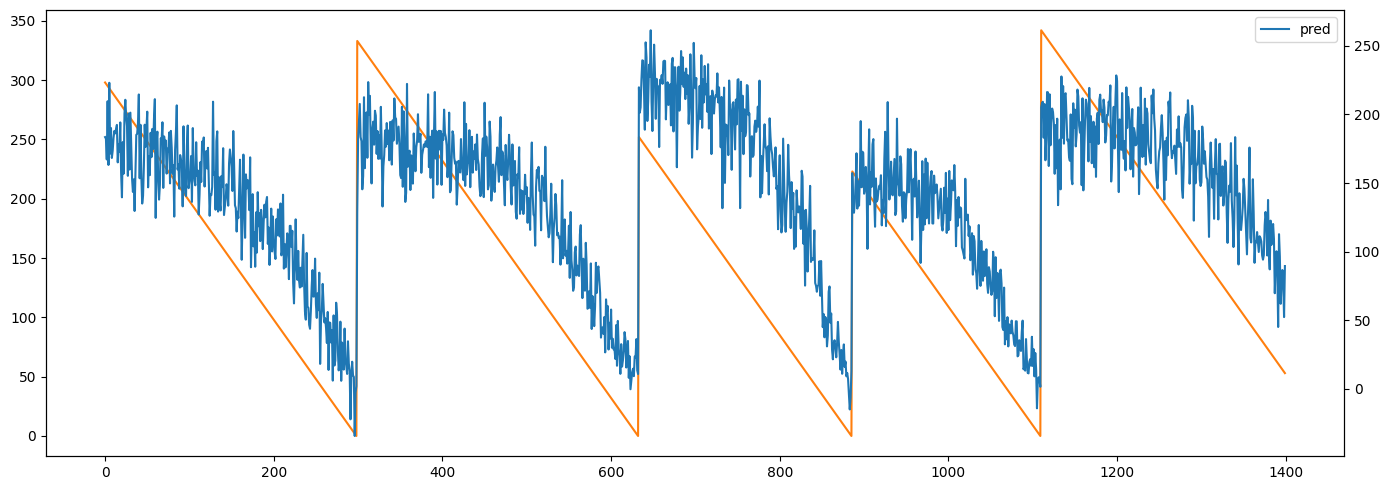

In [86]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [87]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0132
Standard Deviation of MSE: 0.0003


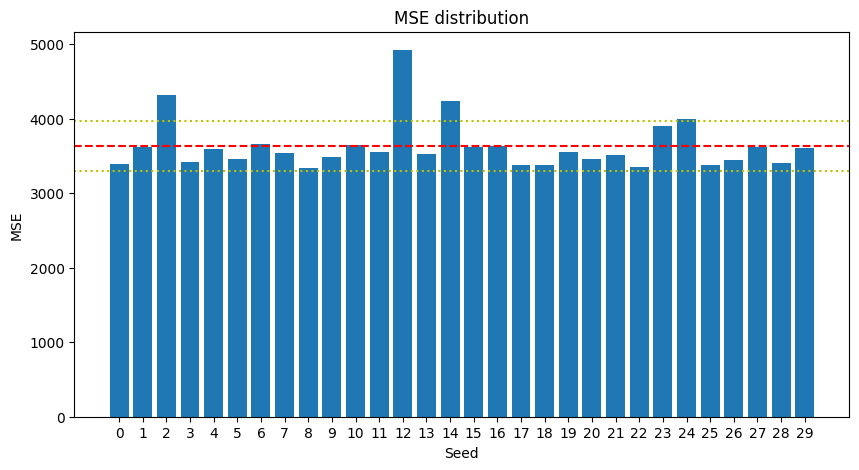

In [367]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [33]:
cst.save_results_to_excel("Task 1.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [29]:
results_task1_2 = pd.read_excel(excel_file_path)
results_task1_2.head()

Task         Mean         Std      Seed_0       Seed_1  Seed_2
0  Task 1.1  4449.200321  388.466231  4060.73409  4837.666551     NaN
1  Task 1.2  4449.200321  388.466231  4060.73409  4837.666551     NaN

In [30]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-2.xlsx')

In [31]:
pd.read_excel('./predictions/predictions-1-2.xlsx').head(10)

Seed_0      Seed_1  rul
0  211.759918  206.417938  298
1  189.309464  202.731842  297
2  189.211624  193.479462  296
3  226.520065  226.151413  295
4  197.447006  257.995422  294
5  222.880829  214.664459  293
6  183.047821  178.316345  292
7  217.585800  211.452194  291
8  201.721436  212.158737  290
9  176.886551  192.023575  289

#### 1.3 50% of supervised data used for training

In [88]:
trs_3 = cst.split_data(ts, trs=trs, trs_ratio=0.50)

Num. samples: 18373 (supervised), 15864 (test)


In [89]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs_3, vs, ts, dt_in)

In [90]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-3.log')

Epoch 1/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0243 - mse: 0.0243 - cst: 0.0106 - val_loss: 0.0184 - val_mse: 0.0184 - val_cst: 0.0036
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0157 - mse: 0.0157 - cst: 0.0044 - val_loss: 0.0198 - val_mse: 0.0198 - val_cst: 0.0035
Epoch 3/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0156 - mse: 0.0156 - cst: 0.0043 - val_loss: 0.0159 - val_mse: 0.0159 - val_cst: 0.0025
Epoch 4/5
615/615 [==============================] - 2s 4ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0038 - val_loss: 0.0138 - val_mse: 0.0138 - val_cst: 0.0034
Epoch 5/5
496/496 [==============================] - 0s 734us/step
Epoch 1/5
615/615 [==============================] - 2s 4ms/step - loss: 0.0234 - mse: 0.0234 - cst: 0.0068 - val_loss: 0.0181 - val_mse: 0.0181 - val_cst: 0.0049
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0183 - mse: 0.0183 - cst: 0.0052 - val_loss

Evaluation on the test set

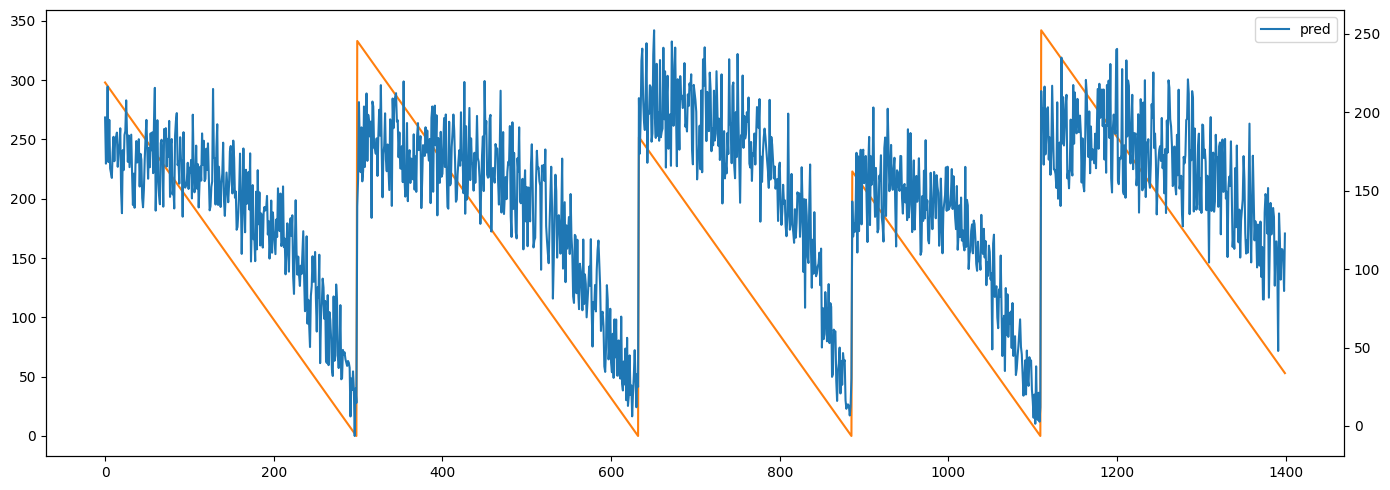

In [93]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [94]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0143
Standard Deviation of MSE: 0.0007


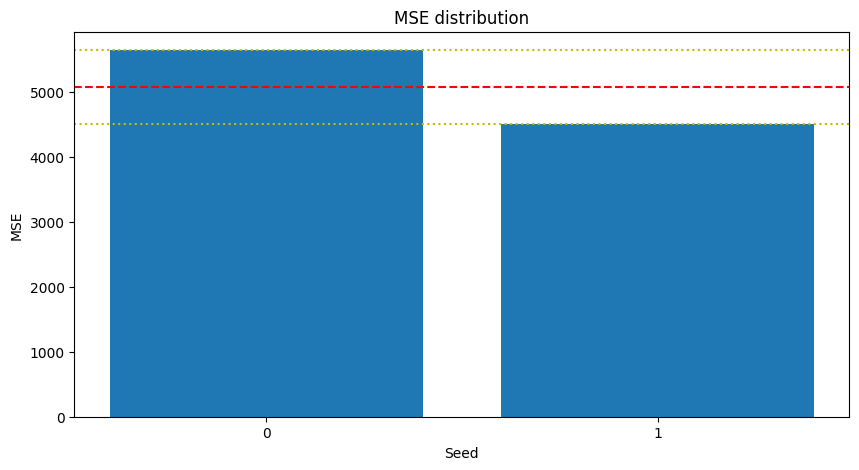

In [43]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [44]:
cst.save_results_to_excel("Task 1.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [45]:
results_task1_3 = pd.read_excel(excel_file_path)
results_task1_3.head()

Task         Mean         Std      Seed_0       Seed_1  Seed_2
0  Task 1.1  4449.200321  388.466231  4060.73409  4837.666551     NaN
1  Task 1.2  4449.200321  388.466231  4060.73409  4837.666551     NaN
2  Task 1.3  5079.337457  571.356063  5650.69352  4507.981395     NaN

In [46]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-3.xlsx')

In [47]:
pd.read_excel('./predictions/predictions-1-3.xlsx').head(10)

Seed_0      Seed_1  rul
0  152.105408  191.217407  298
1  208.146179  196.382126  297
2  136.038956  181.963287  296
3  172.587631  210.188400  295
4   90.048561  181.572968  294
5  233.642746  204.206985  293
6  194.759460  171.159088  292
7  220.900040  183.582336  291
8  197.330170  182.625275  290
9  191.844040  173.469208  289

#### Results on Task 1


In [7]:
results_task1 = pd.read_excel('results.xlsx')

# tieni solo task 1.1 e 1.2
results_task1_1= results_task1[results_task1['Task'] == 'Task 1.1']
results_task1_2 = results_task1[results_task1['Task'] == 'Task 1.2']
results_task1_3 = results_task1[results_task1['Task'] == 'Task 1.3']


drop_columns = ['Seed_0', 'Seed_1', 'Seed_2'] # col to drop aggiungere gli altri seed !! 
res_task1 = pd.concat([results_task1_1, results_task1_2, results_task1_3]).drop(columns=drop_columns)

print(tabulate(res_task1, headers='keys', showindex= False, tablefmt='psql'))

+----------+--------------+---------------+
| Task     |         Mean |           Std |
|----------+--------------+---------------|
| Task 1.1 |    0.0128889 |   0.000392717 |
| Task 1.2 | 4449.2       | 388.466       |
| Task 1.3 | 5079.34      | 571.356       |
+----------+--------------+---------------+


Task 1 uses only supervised data, as we expected (..) the best model is the one that uses 100% of the data, but the other two don't have such worse performances. 
The mean of the *mse* metric is quite low, mainly because it is computed on standardized data. Indeed, if we observe closer the prediction  (non standardize) we observe that there is a quite great gap between the real rul value and the predicted one. 

In [20]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-1-2.xlsx')
print(tabulate(rul_values[0:298], showindex= False, headers=['Seed 1', 'Seed 2', 'RUL'],  tablefmt='psql'))

+----------+----------+-------+
|   Seed 1 |   Seed 2 |   RUL |
|----------+----------+-------|
| 211.76   | 206.418  |   298 |
| 189.309  | 202.732  |   297 |
| 189.212  | 193.479  |   296 |
| 226.52   | 226.151  |   295 |
| 197.447  | 257.995  |   294 |
| 222.881  | 214.664  |   293 |
| 183.048  | 178.316  |   292 |
| 217.586  | 211.452  |   291 |
| 201.721  | 212.159  |   290 |
| 176.887  | 192.024  |   289 |
| 185.412  | 202.798  |   288 |
| 189.847  | 191.802  |   287 |
| 185.859  | 209.879  |   286 |
| 202.112  | 205.976  |   285 |
| 203.753  | 200.679  |   284 |
| 167.999  | 188.374  |   283 |
| 173.233  | 202.084  |   282 |
| 193.761  | 184.379  |   281 |
| 193.022  | 199.776  |   280 |
| 188.983  | 215.699  |   279 |
| 170.94   | 208.27   |   278 |
| 177.058  | 186.941  |   277 |
| 191.139  | 257.511  |   276 |
| 200.492  | 206.602  |   275 |
| 210.415  | 211.721  |   274 |
| 218.866  | 215.797  |   273 |
| 205.446  | 198.94   |   272 |
| 177.904  | 172.407  |   271 |
| 212.88

We just printed the predictions for the first machine in the test set. the model is able to guess an inital *rul* closer (but still not perfefct) to the starting *rul* value, and in the end the last values of the *rul* are low and in general quite close to 0. Moreover, we can observe that the model understand well the decreasing trend that a *rul* must follow.
To conclude, the overall results are a rough approximation of the behavior expected, they are not perfect but the initial and  final values are close to the right ones and the trend they follow too.

### **Task 2**: train the model with only unsupervised data. We will experiment with different ratios of supervised data. 


While training the models only with unsupervised data, we do not have great expectations. Indeed, using only unsupervised data there is no way the model can learn to predict the RUL. However, we will see if it is possible for the regressor to learn the constraint which imposes that the RUL for a machine should decrease. In comparison with the full supervised models, we expect that unsupervised models won't be able to predict the initial RUL as accurately as the supervised models.
In general, we expect that the perormances will be worse with respect the superivised experiments.

In [95]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 149 (unsupervised), 37 (validation), 63 (test)


In [96]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 36746 (unsupervised), 8639 (validation), 15864 (test)


#### 100% of unsupervised data

In [97]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)

Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [98]:
tru_st = cst.remove_rul(tru_s)
vs_st = cst.remove_rul(vs_s)

In [99]:
history, predictions = train_model(train_data=tru_st, val_data=vs_st, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-1.log')


Epoch 1/5
1079/1079 [==============================] - 3s 3ms/step - loss: 0.0048 - mse: 0.0000e+00 - cst: 0.0048 - val_loss: 4.8906e-04 - val_mse: 0.0000e+00 - val_cst: 4.8906e-04
Epoch 2/5
1079/1079 [==============================] - 3s 3ms/step - loss: 4.6191e-04 - mse: 0.0000e+00 - cst: 4.6191e-04 - val_loss: 3.4853e-04 - val_mse: 0.0000e+00 - val_cst: 3.4853e-04
Epoch 3/5
1079/1079 [==============================] - 3s 3ms/step - loss: 4.4966e-04 - mse: 0.0000e+00 - cst: 4.4966e-04 - val_loss: 3.3860e-04 - val_mse: 0.0000e+00 - val_cst: 3.3860e-04
Epoch 4/5
1079/1079 [==============================] - 3s 3ms/step - loss: 4.6085e-04 - mse: 0.0000e+00 - cst: 4.6085e-04 - val_loss: 3.2470e-04 - val_mse: 0.0000e+00 - val_cst: 3.2470e-04
Epoch 5/5
496/496 [==============================] - 0s 393us/step
Epoch 1/5
1079/1079 [==============================] - 3s 3ms/step - loss: 0.0021 - mse: 0.0000e+00 - cst: 0.0021 - val_loss: 4.5737e-04 - val_mse: 0.0000e+00 - val_cst: 4.5737e-04
Epoc

Evaluation on the test set

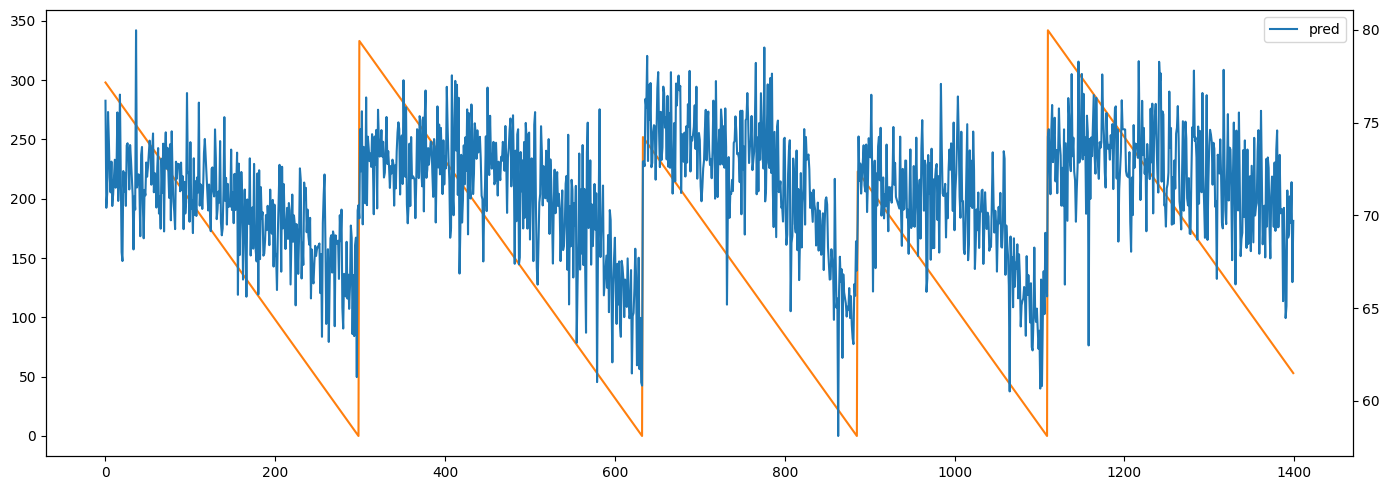

In [53]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [100]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0700
Standard Deviation of MSE: 0.0153


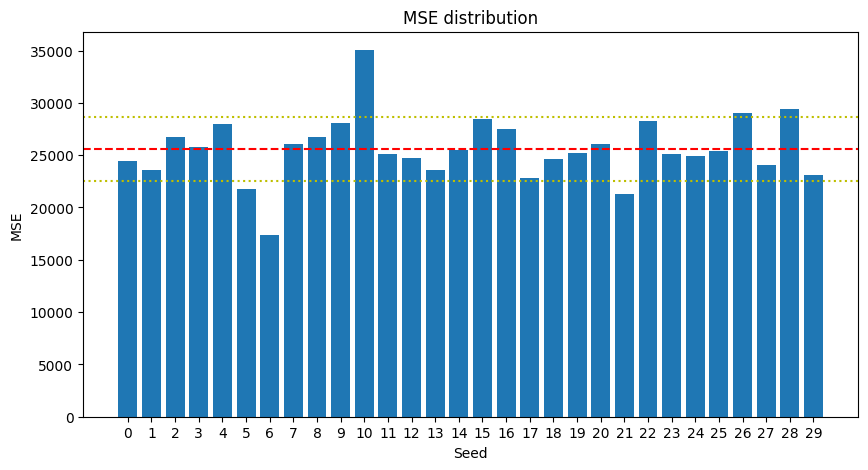

In [382]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

 Save results and predictions on excel files and show them

In [55]:
cst.save_results_to_excel("Task 2.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [56]:
results_task2_1 = pd.read_excel(excel_file_path)
results_task2_1.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [57]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-1.xlsx')

In [58]:
pd.read_excel('./predictions/predictions-2-1.xlsx').head(10)

Seed_0     Seed_1  rul
0  76.173302  13.961440  298
1  70.402443  15.141240  297
2  71.187805  13.900810  296
3  75.566689  13.785439  295
4  73.996017   7.561786  294
5  72.044754  14.722753  293
6  71.235741   8.630589  292
7  72.892097   8.290474  291
8  70.499504   7.455242  290
9  71.110764   6.772154  289

**Results**

#### 75% of unsupervised data

In [101]:
tru_2 = cst.split_data(ts, tru=tru, tru_ratio=0.75)

Num. samples: 27559 (unsupervised), 15864 (test)


In [102]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru_2, vs, ts, dt_in)

In [103]:
tru_st = cst.remove_rul(tru_s)
vs_st = cst.remove_rul(vs_s)

In [104]:
history, predictions = train_model(train_data=tru_st, val_data=vs_st, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-2.log')

Epoch 1/5
812/812 [==============================] - 2s 3ms/step - loss: 0.0047 - mse: 0.0000e+00 - cst: 0.0047 - val_loss: 4.7982e-04 - val_mse: 0.0000e+00 - val_cst: 4.7982e-04
Epoch 2/5
812/812 [==============================] - 2s 3ms/step - loss: 5.4668e-04 - mse: 0.0000e+00 - cst: 5.4668e-04 - val_loss: 4.4839e-04 - val_mse: 0.0000e+00 - val_cst: 4.4839e-04
Epoch 3/5
812/812 [==============================] - 2s 3ms/step - loss: 5.0930e-04 - mse: 0.0000e+00 - cst: 5.0930e-04 - val_loss: 4.3809e-04 - val_mse: 0.0000e+00 - val_cst: 4.3809e-04
Epoch 4/5
812/812 [==============================] - 3s 3ms/step - loss: 4.7721e-04 - mse: 0.0000e+00 - cst: 4.7721e-04 - val_loss: 0.0017 - val_mse: 0.0000e+00 - val_cst: 0.0017
Epoch 5/5
496/496 [==============================] - 0s 385us/step
Epoch 1/5
812/812 [==============================] - 2s 3ms/step - loss: 0.0025 - mse: 0.0000e+00 - cst: 0.0025 - val_loss: 6.1766e-04 - val_mse: 0.0000e+00 - val_cst: 6.1766e-04
Epoch 2/5
812/812 [===

Evaluation on the test set

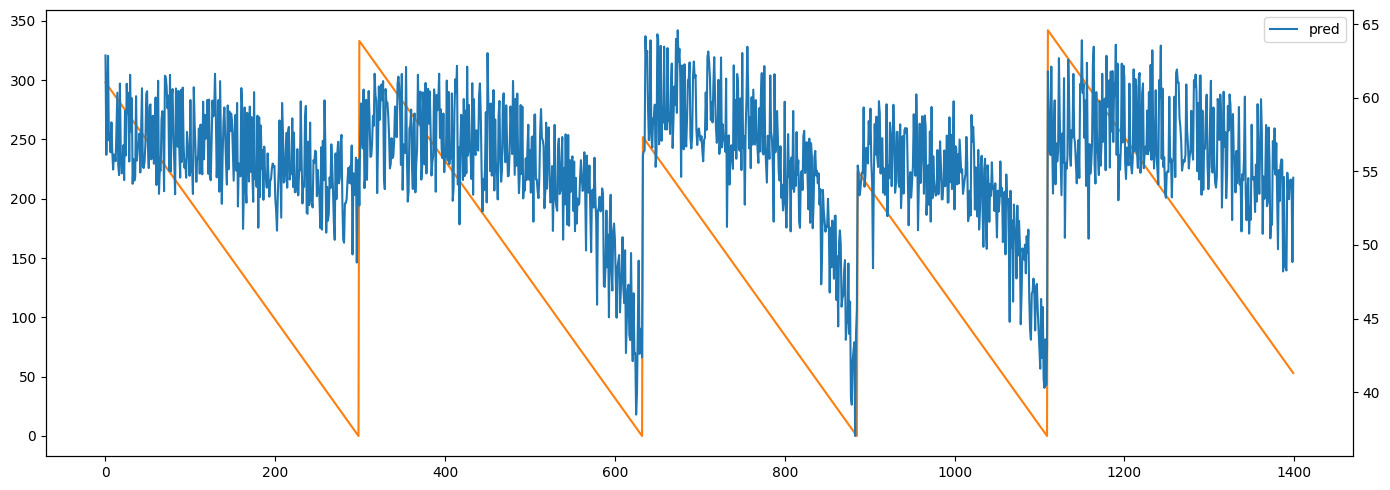

In [105]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [106]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0648
Standard Deviation of MSE: 0.0160


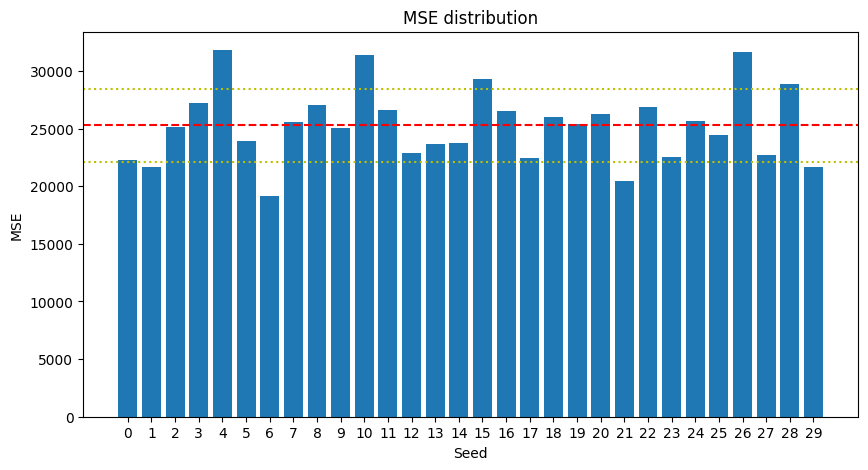

In [389]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [63]:
cst.save_results_to_excel("Task 2.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [64]:
results_task2_2 = pd.read_excel(excel_file_path)
results_task2_2.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [65]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-2.xlsx')

In [66]:
pd.read_excel('./predictions/predictions-2-2.xlsx').head(10)

Seed_0     Seed_1  rul
0  78.884789  23.671032  298
1  67.454712  31.920053  297
2  73.506699  23.019428  296
3  78.012886  24.198143  295
4  67.857819  30.240625  294
5  69.601700  29.605576  293
6  69.056114  25.393200  292
7  69.369682  26.292801  291
8  67.784874  25.090641  290
9  73.800102  29.122023  289

**Results**

#### 50% of unsupervised

In [107]:
tru_3 = cst.split_data(ts, tru=tru, tru_ratio=0.50)

Num. samples: 18373 (unsupervised), 15864 (test)


In [108]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru_3, vs, ts, dt_in)

In [109]:
tru_st = cst.remove_rul(tru_s)
vs_st = cst.remove_rul(vs_s)

In [113]:
history, predictions = train_model(train_data=tru_st, val_data=vs_st, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-3.log')

Epoch 1/5
541/541 [==============================] - 2s 3ms/step - loss: 0.0072 - mse: 0.0000e+00 - cst: 0.0072 - val_loss: 5.7786e-04 - val_mse: 0.0280 - val_cst: 5.7786e-04
Epoch 2/5
541/541 [==============================] - 1s 3ms/step - loss: 4.8538e-04 - mse: 0.0000e+00 - cst: 4.8538e-04 - val_loss: 4.9844e-04 - val_mse: 0.0289 - val_cst: 4.9844e-04
Epoch 3/5
541/541 [==============================] - 2s 3ms/step - loss: 4.4765e-04 - mse: 0.0000e+00 - cst: 4.4765e-04 - val_loss: 4.9353e-04 - val_mse: 0.0298 - val_cst: 4.9353e-04
Epoch 4/5
541/541 [==============================] - 1s 3ms/step - loss: 4.5155e-04 - mse: 0.0000e+00 - cst: 4.5155e-04 - val_loss: 4.3910e-04 - val_mse: 0.0326 - val_cst: 4.3910e-04
Epoch 5/5
496/496 [==============================] - 0s 375us/step
Epoch 1/5
541/541 [==============================] - 2s 3ms/step - loss: 0.0036 - mse: 0.0000e+00 - cst: 0.0036 - val_loss: 6.1194e-04 - val_mse: 0.0466 - val_cst: 6.1194e-04
Epoch 2/5
541/541 [===============

Evaluation on the test set

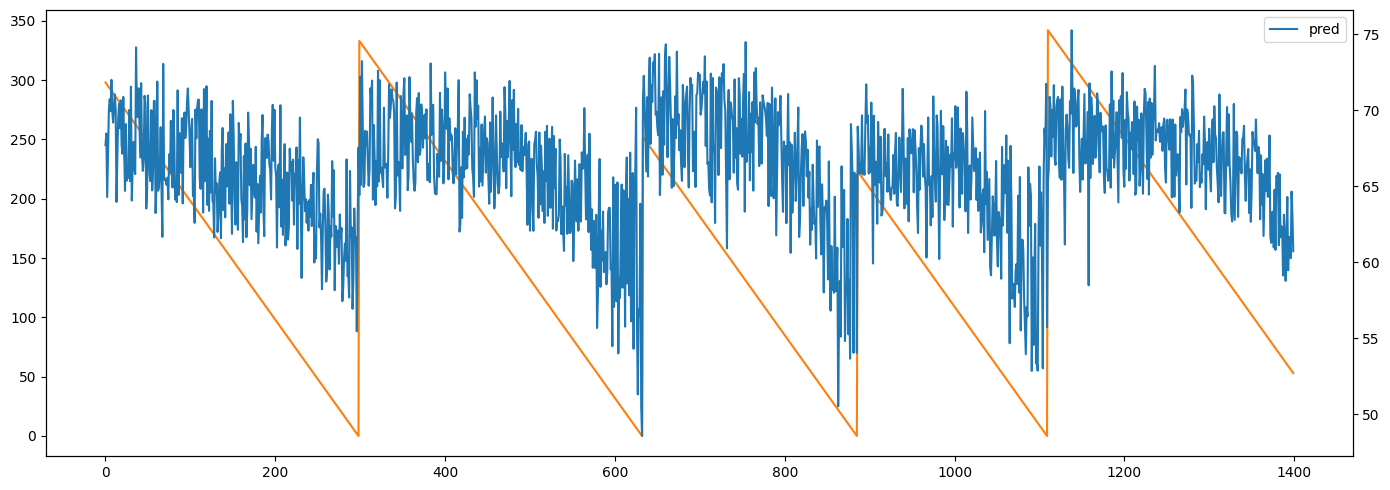

In [114]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [115]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0587
Standard Deviation of MSE: 0.0151


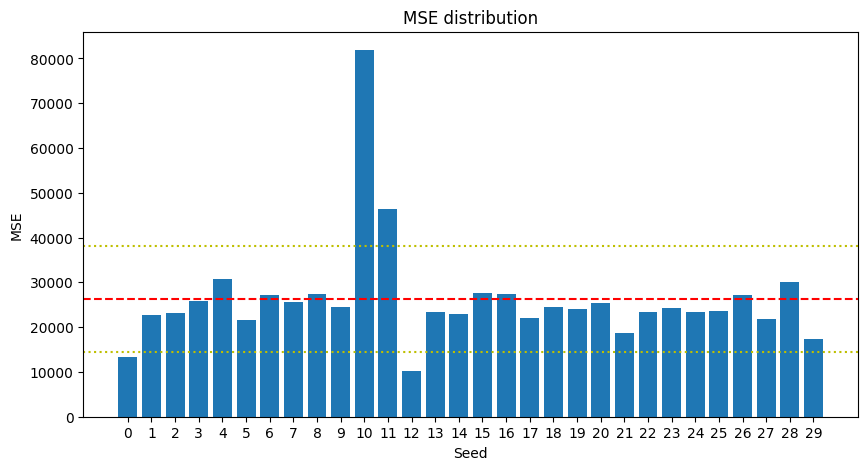

In [399]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

 Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 2.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task2_3 = pd.read_excel(excel_file_path)
results_task2_3.head()

Task         Mean         Std      Seed_0       Seed_1  Seed_2
0  Task 1.1  4449.200321  388.466231  4060.73409  4837.666551     NaN
1  Task 1.2  4449.200321  388.466231  4060.73409  4837.666551     NaN
2  Task 1.3  5079.337457  571.356063  5650.69352  4507.981395     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-3.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-2-3.xlsx').head(10)

Seed_0      Seed_1  rul
0  152.105408  191.217407  298
1  208.146179  196.382126  297
2  136.038956  181.963287  296
3  172.587631  210.188400  295
4   90.048561  181.572968  294
5  233.642746  204.206985  293
6  194.759460  171.159088  292
7  220.900040  183.582336  291
8  197.330170  182.625275  290
9  191.844040  173.469208  289

**results**
meglio del previsto

#### Results on Task 2

In [9]:
results_task2 = pd.read_excel('results.xlsx')

# tieni solo task 2.1 e 2.2
results_task2_1= results_task2[results_task2['Task'] == 'Task 2.1']
results_task2_2 = results_task2[results_task2['Task'] == 'Task 2.2']
results_task2_3 = results_task2[results_task2['Task'] == 'Task 2.3']


drop_columns = ['Seed_0', 'Seed_1', 'Seed_2'] # col to drop aggiungere gli altri seed !! 
res_task2 = pd.concat([results_task2_1, results_task2_2, results_task2_3]).drop(columns=drop_columns)

print(tabulate(res_task2, headers='keys', showindex= False, tablefmt='psql'))

+----------+---------+---------+
| Task     |    Mean |     Std |
|----------+---------+---------|
| Task 2.1 | 18290.6 | 6147.15 |
| Task 2.2 | 18290.6 | 6147.15 |
+----------+---------+---------+


Task 2, differentlty from Task 1, uses only unsupervised data. Meaning that there is no information on the RUL while training the models. For this reason we expected that ........ . 
In comparison with Task  1, the models ..... . However, these unsupervised models understand quite well the decrasing trend of the *rul*. On the other hand, the exacgt values of the predicted *rul* are quite erroneus with respect to the true *rul*, (INIZIANO DA VALORI MOLTO PIU BASSI E NON CALANO DI TANTO)


In [ ]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-2-2.xlsx')
print(tabulate(rul_values[0:298], showindex= False, headers=['Seed 1', 'Seed 2', 'RUL'],  tablefmt='psql'))

Osservazioni sulle predictions stamapte: trend ok ma non si azzeccano tanto

### **Task 3**: train the model with both supervised and unsupervised data. We will experiment with different ratios of unsupervised and supervised data. 


We expect that the performances of models trained with both supervised and unsupervied data will lay in between those of the models trained just with supervised data and the models trained with only unsupervised data, meaning that they will have better performances wrt the unsupervised models, but worse than those of supervised models. Moreover, changing the ratio will greatly influence the performances of the models. *scrivere per le combinazioni*
- a) increasing the number of supervised samples (25%, 50%, 100%), with fixed unsupervised samples, will lead to a more performing model
- b) increasing the number of unsupervised samples (25%, 50%, 100%), with fixed supervised samples, will lead to a less improvement in the performances with respect to a.



In [118]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


##### 3.1 100% unsupervised, 100% supervised

In [119]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 14813 (unsupervised), 15864 (validation), 2748 (test)


In [69]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [70]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-1.log')

Epoch 1/2
439/439 [==============================] - 9s 18ms/step - loss: 0.0060 - mse: 0.0000e+00 - cst: 0.0060 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_cst: 0.0000e+00 - val_val_loss: 0.0000e+00 - val_val_mse: 0.0000e+00 - val_val_cst: 0.0000e+00
Epoch 2/2
496/496 [==============================] - 2s 3ms/step
Epoch 1/2
439/439 [==============================] - 9s 18ms/step - loss: 0.0049 - mse: 0.0000e+00 - cst: 0.0049 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_cst: 0.0000e+00 - val_val_loss: 0.0000e+00 - val_val_mse: 0.0000e+00 - val_val_cst: 0.0000e+00
Epoch 2/2
496/496 [==============================] - 1s 2ms/step


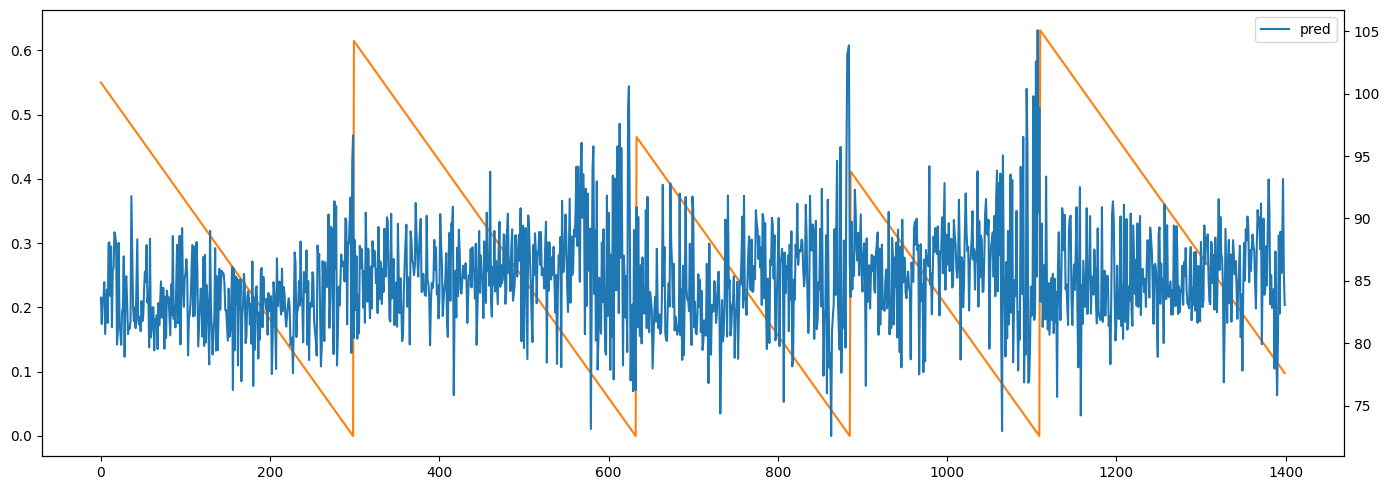

In [71]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [72]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 4192.3815
Standard Deviation of MSE: 3017.9030


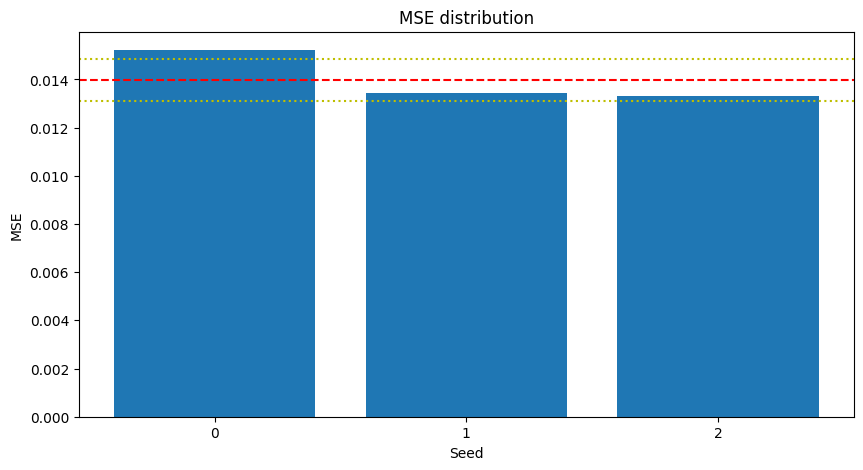

In [99]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [74]:
cst.save_results_to_excel("Task 3.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [75]:
results_task3_1 = pd.read_excel(excel_file_path)
results_task3_1.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [76]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-1.xlsx')

In [77]:
pd.read_excel('./predictions/predictions-3-1.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.2 100% unsupervised, 75% supervised

In [78]:
ratio_sup = 0.75 # 50 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 22929 (supervised), 14813 (unsupervised), 15864 (test)


In [79]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-2.log')

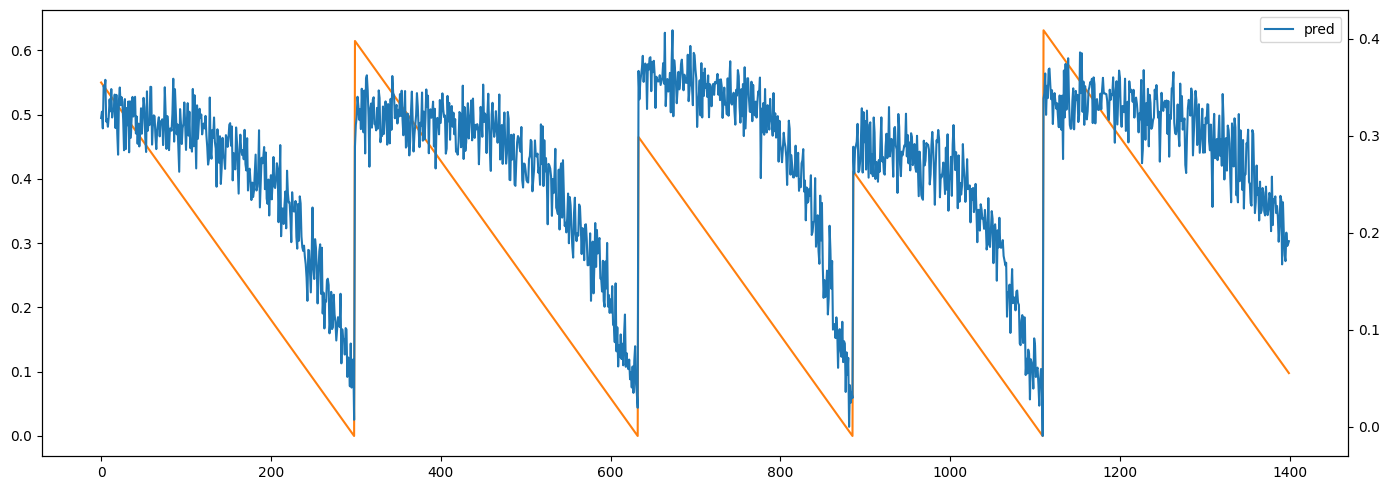

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0153
Deviazione standard della MSE: 0.0017


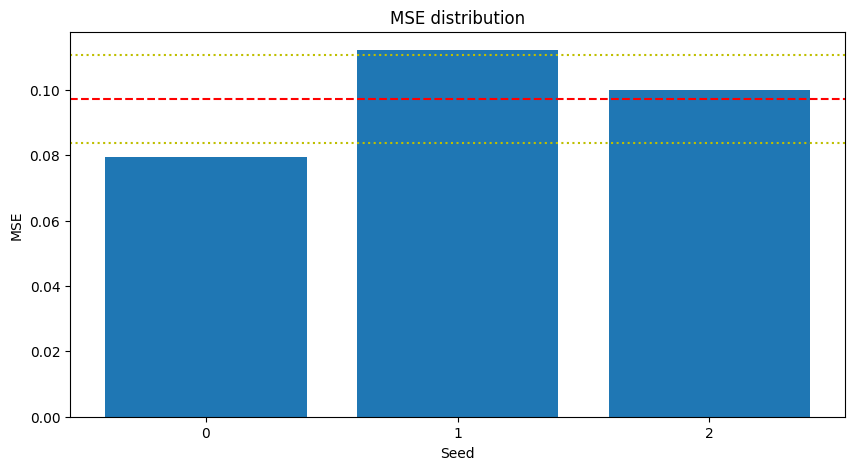

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_2 = pd.read_excel(excel_file_path)
results_task3_2.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-2.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-2.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.3 100% unsupervised, 50% supervised

In [ ]:
ratio_sup = 0.50 # 50 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 22929 (supervised), 14813 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-3.log')

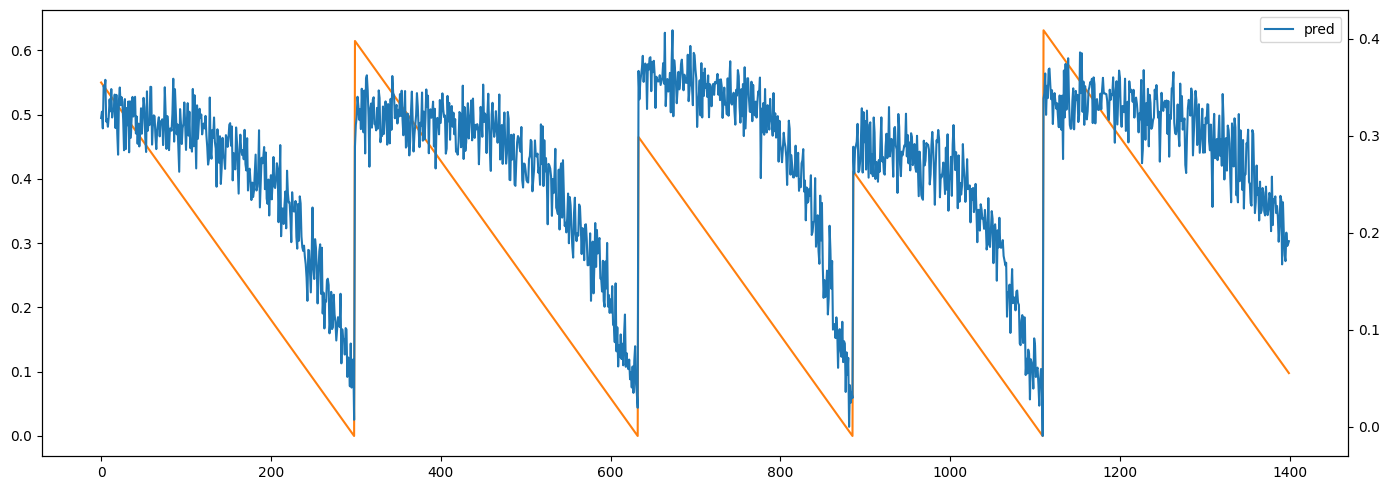

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0153
Deviazione standard della MSE: 0.0017


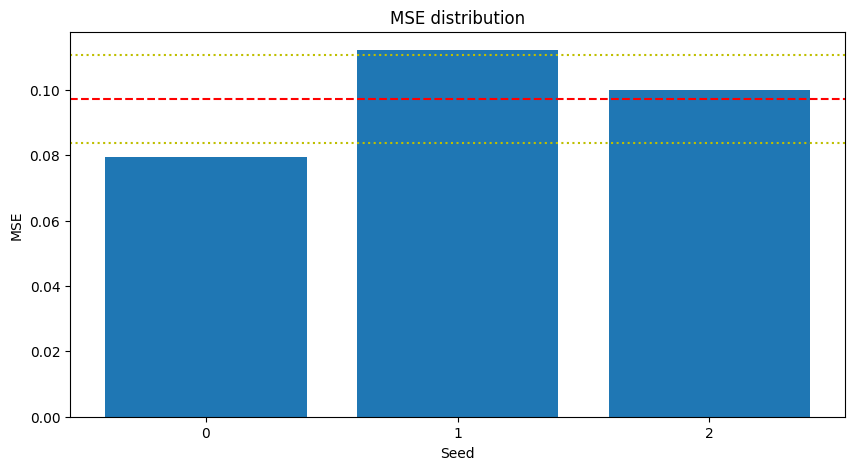

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_3 = pd.read_excel(excel_file_path)
results_task3_3.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-3.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-3.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.4 100% unsupervised, 25% supervised

In [107]:
ratio_sup = 0.25 # 20 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 3821 (supervised), 14813 (unsupervised), 15864 (test)


In [108]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [ ]:
history, predictions = train_model(train_data=trsu_s,  val_data =vs_s,  test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-4.log')

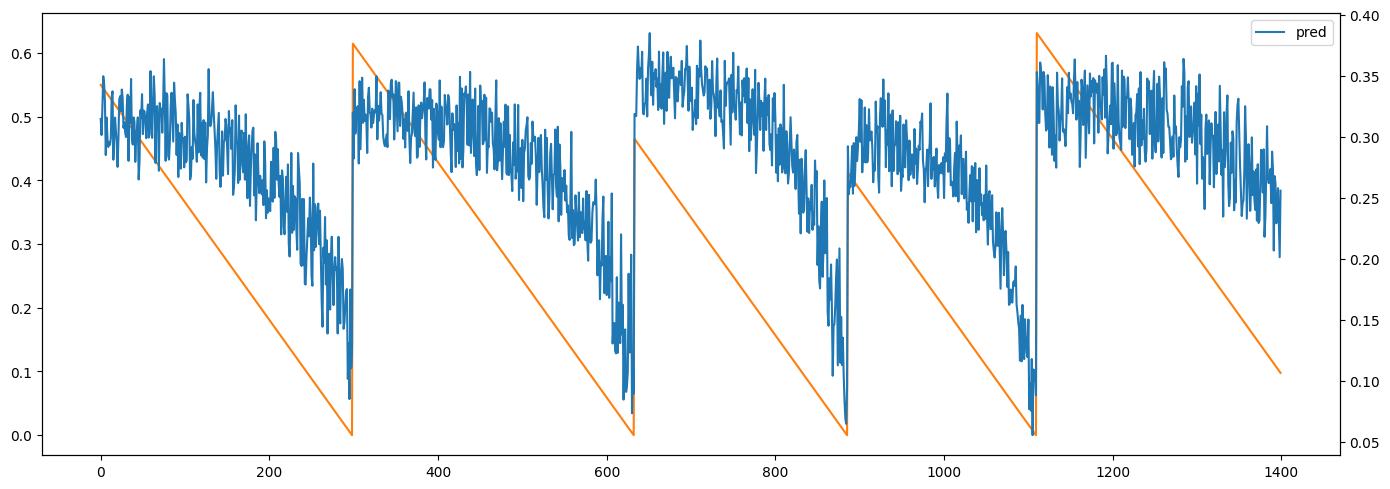

In [112]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [113]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0193
Deviazione standard della MSE: 0.0015


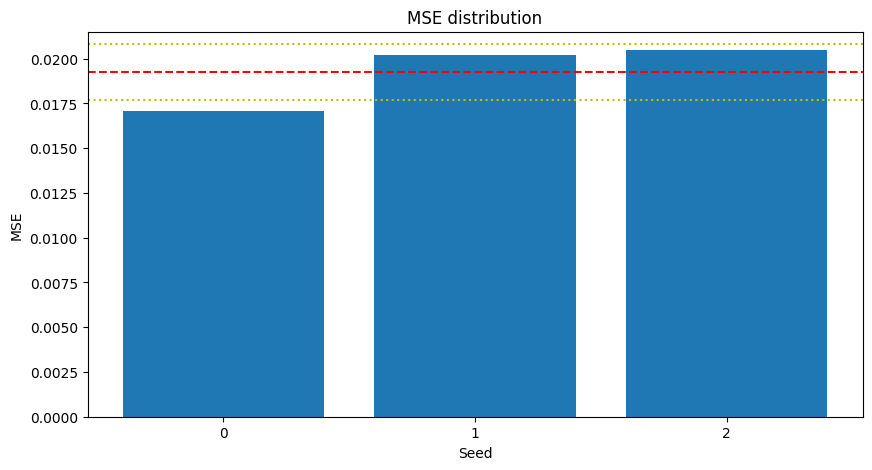

In [114]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.4", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_4 = pd.read_excel(excel_file_path)
results_task3_4.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-4.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-4.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.5 100% supervised, 50% unsupervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [117]:
ratio_unsup = 0.50 # 50% of unsupervised 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [80]:
trs_s, tru_s, ts_s, vs_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s,  val_data =vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-5.log')

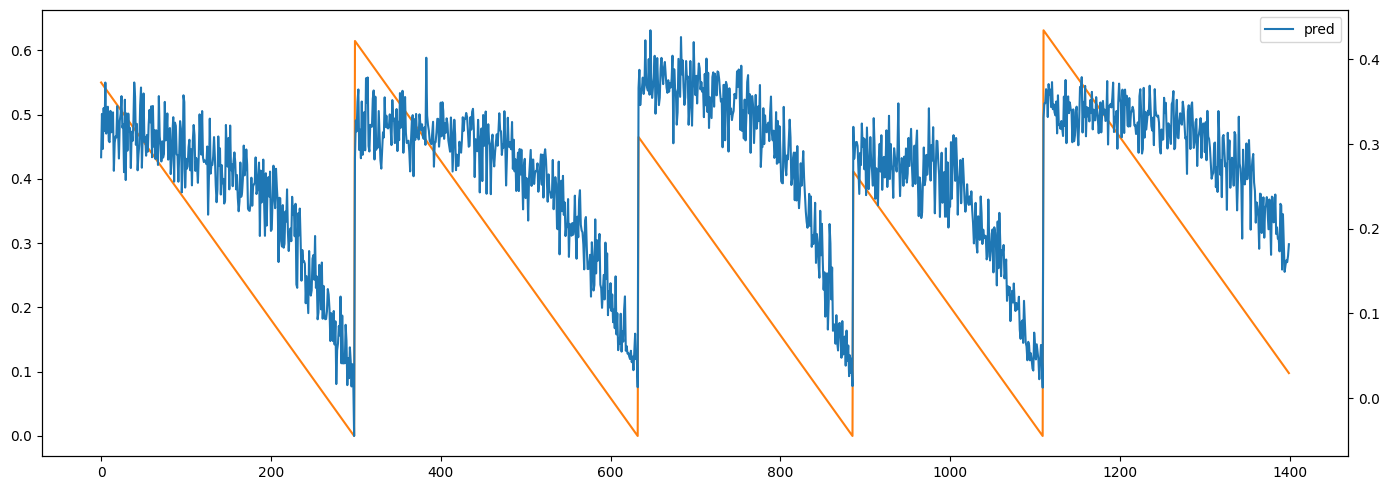

In [122]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [123]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


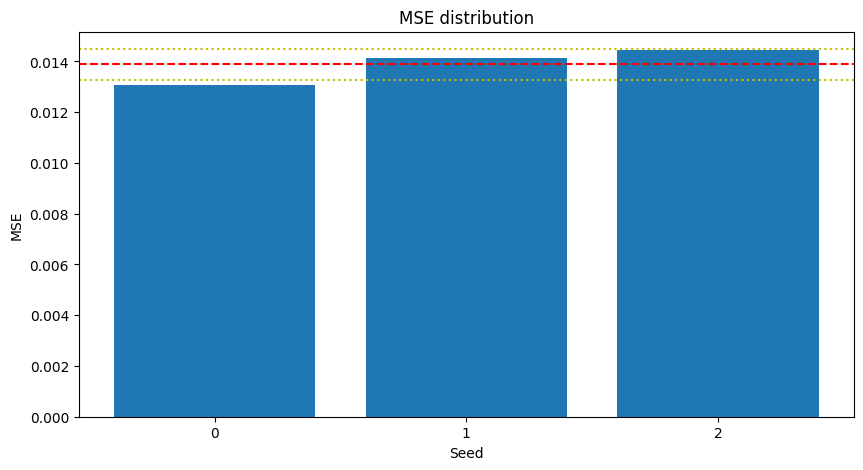

In [124]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.5", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_5 = pd.read_excel(excel_file_path)
results_task3_5.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-5.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-5.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.6 100% supervised, 75% unsupervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.75 # 50% of unsupervised 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-6.log')

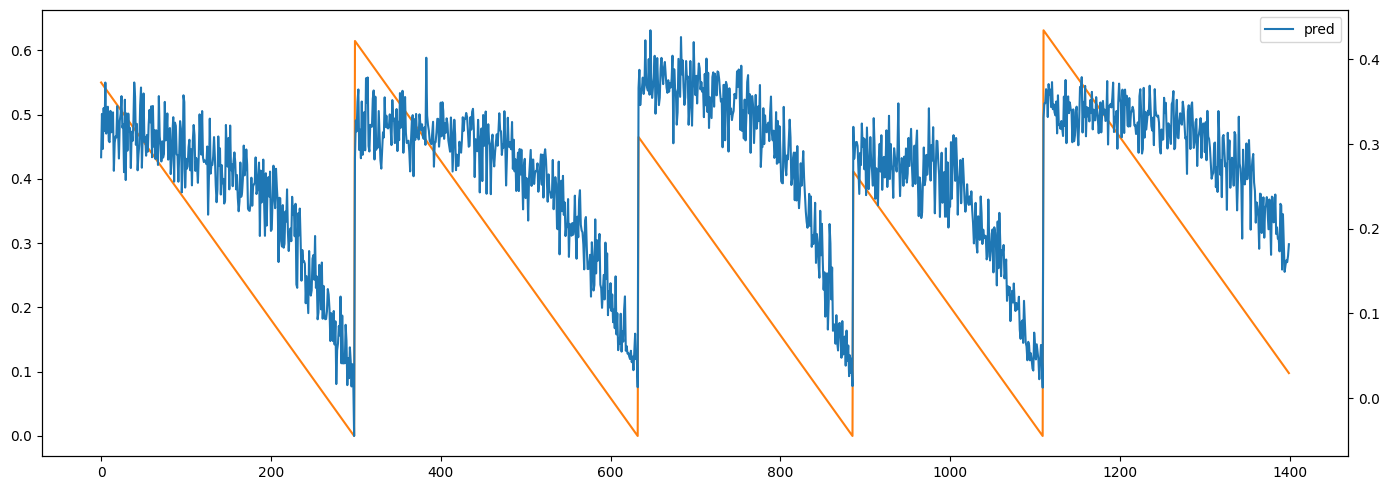

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


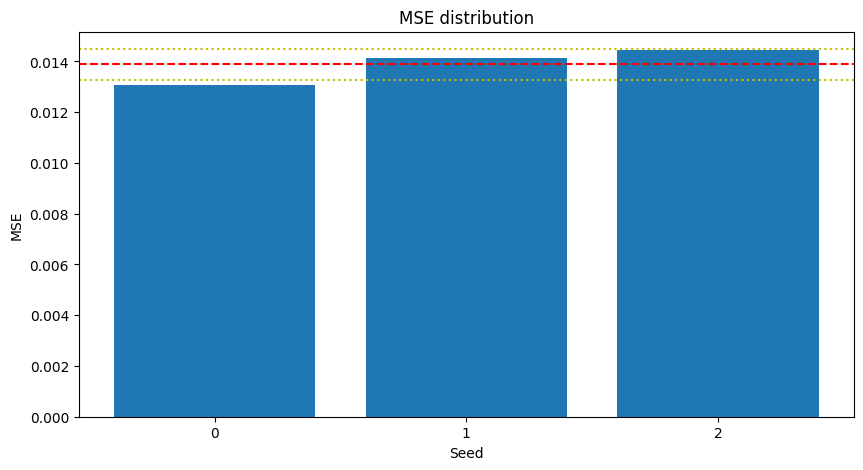

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.6", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_6 = pd.read_excel(excel_file_path)
results_task3_6.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-6.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-6.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.7 100% supervised, 25% unsupervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.25 # 50% of unsupervised 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-7.log')

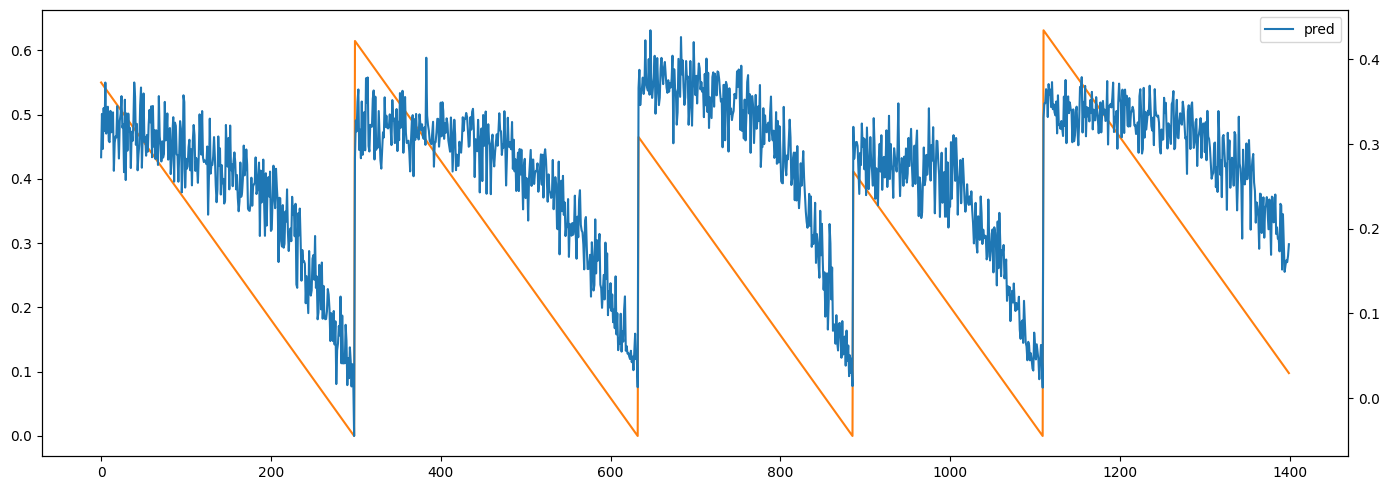

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


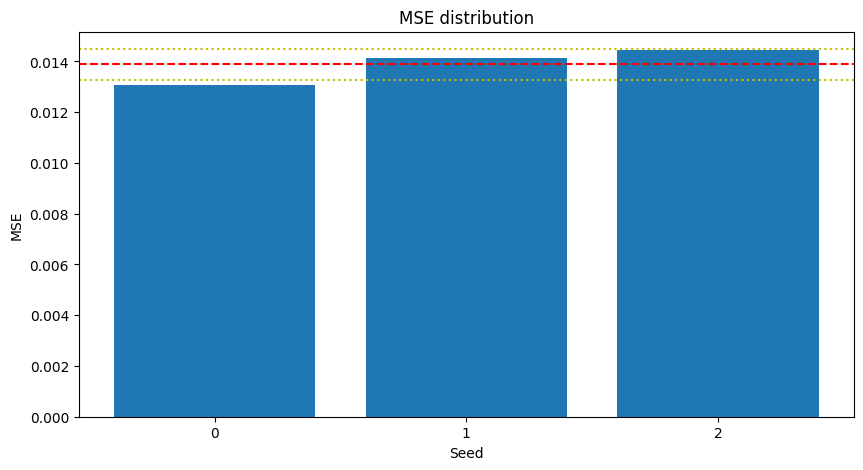

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.7", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_7 = pd.read_excel(excel_file_path)
results_task3_7.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-7.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-7.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.8 75% unsupervised, 75% supervised

In [ ]:
tr, ts, trs, tru = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.75 # 50% of unsupervised 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-8.log')

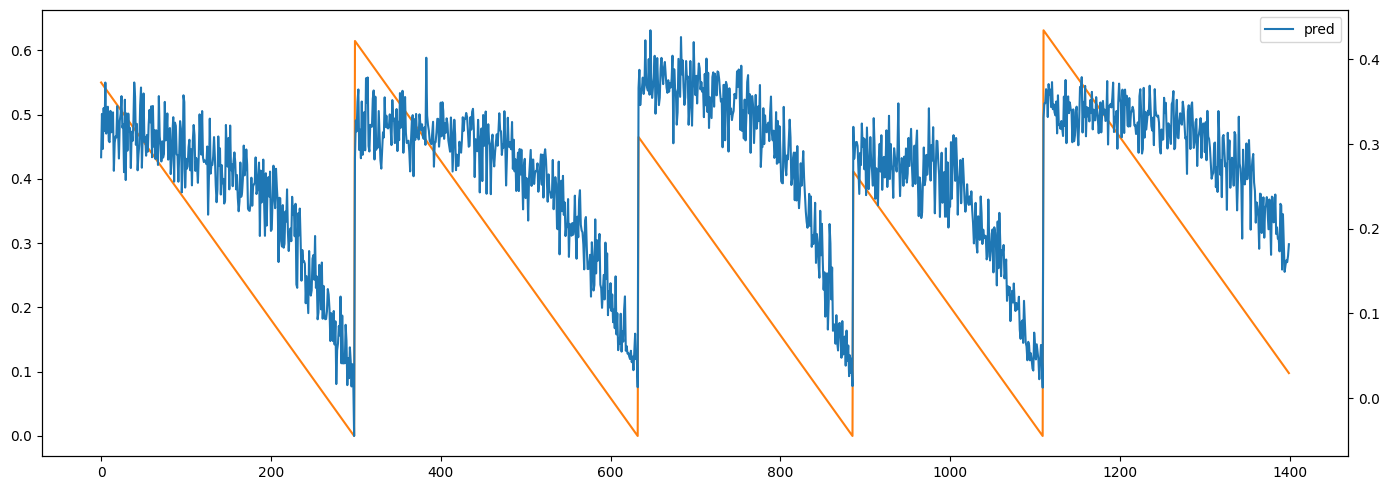

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


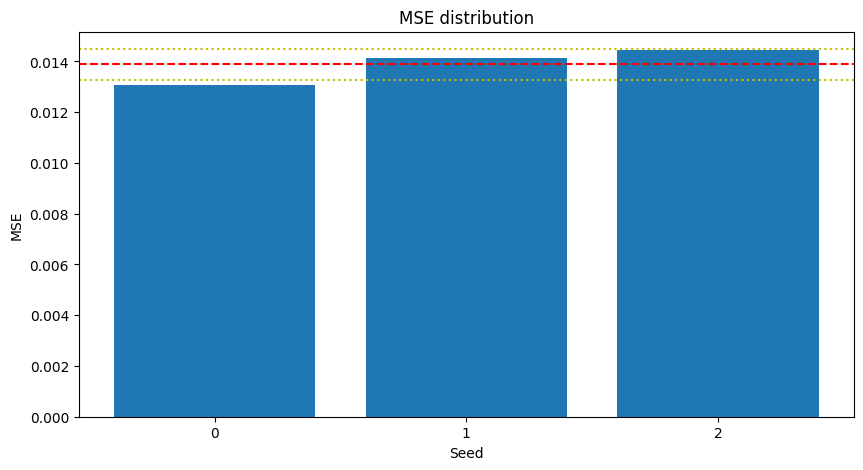

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.8", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_8 = pd.read_excel(excel_file_path)
results_task3_8.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-8.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-8.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.9 75% unsupervised, 50% supervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.75 
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-9.log')

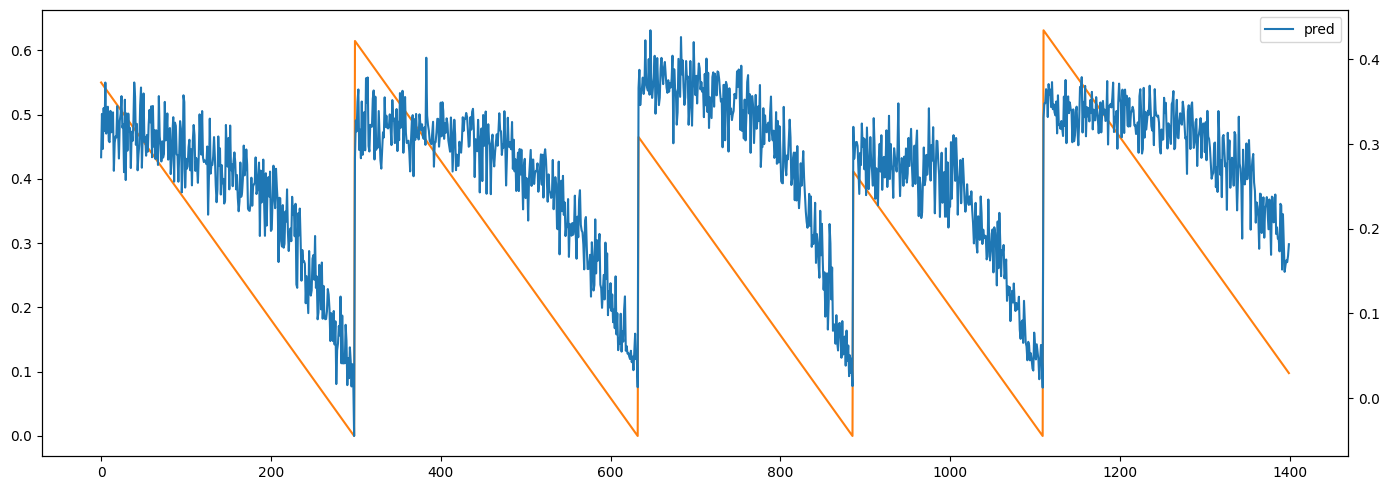

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


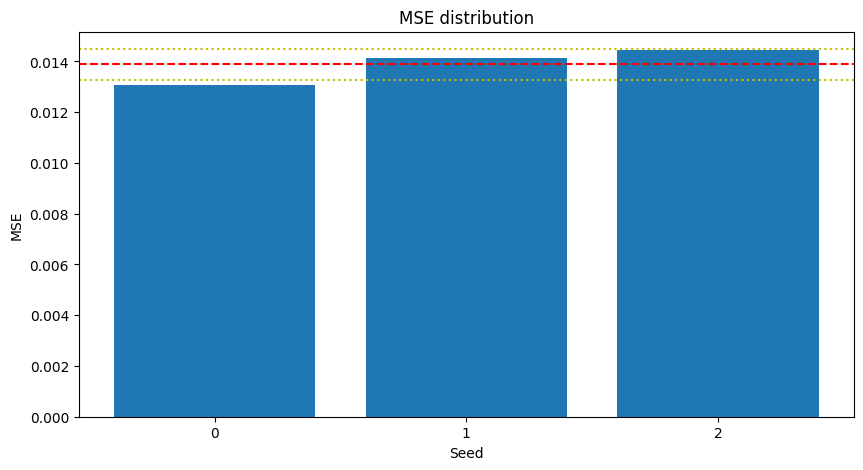

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.9", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_9 = pd.read_excel(excel_file_path)
results_task3_9.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-9.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-9.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.10 75% unsupervised, 25% supervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.75 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-10.log')

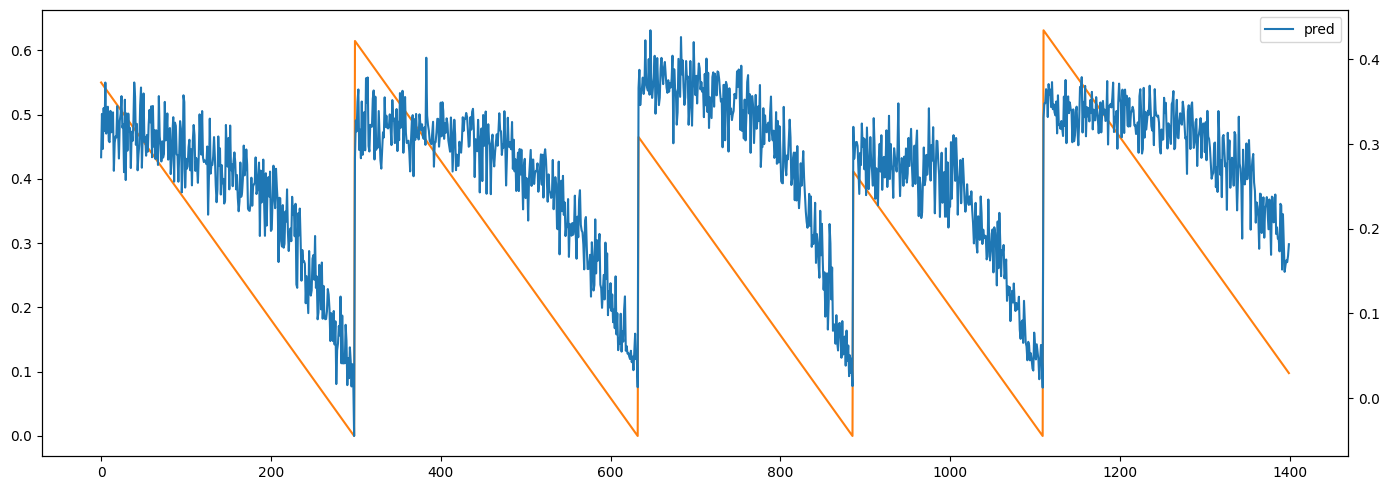

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


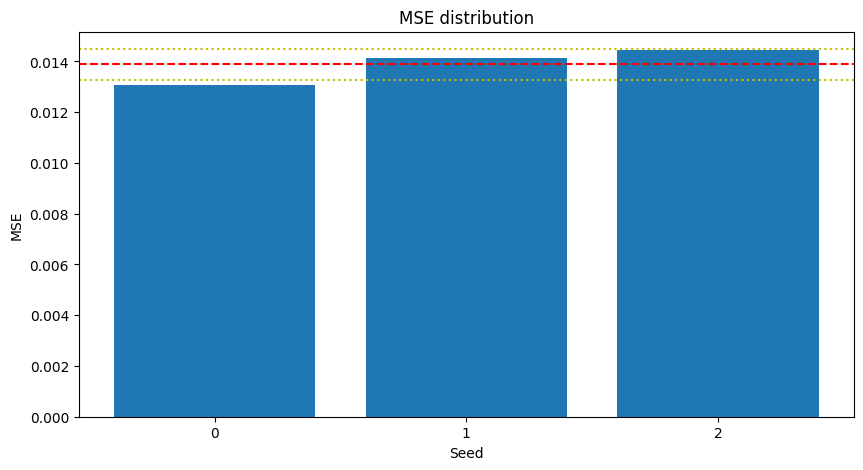

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.10", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_10= pd.read_excel(excel_file_path)
results_task3_10.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-10.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-10.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.11 50% unsupervised, 75% supervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.50 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-11.log')

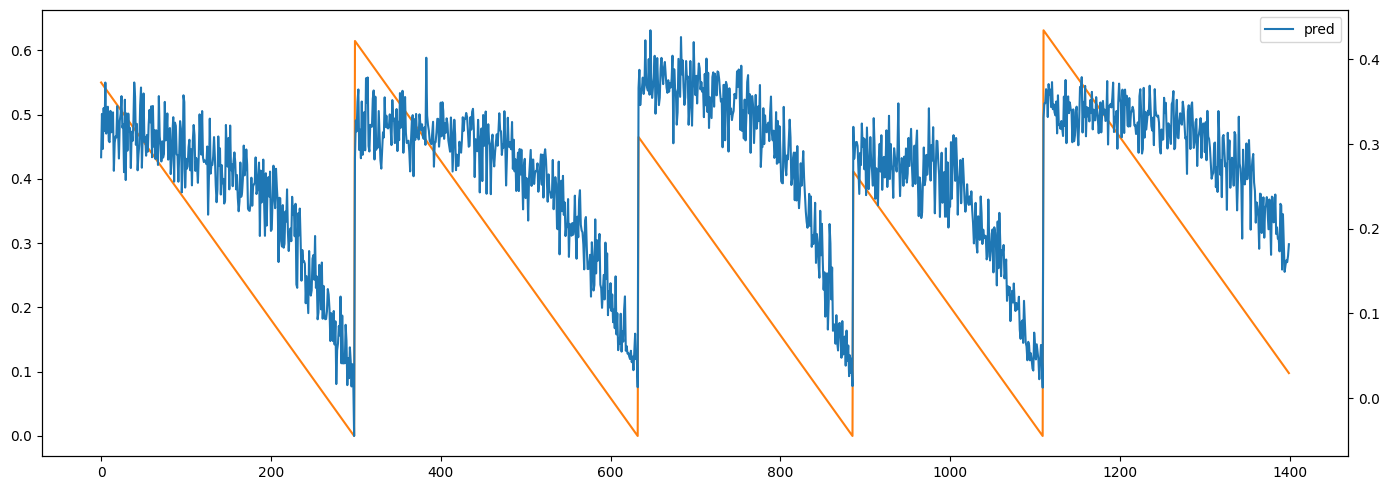

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


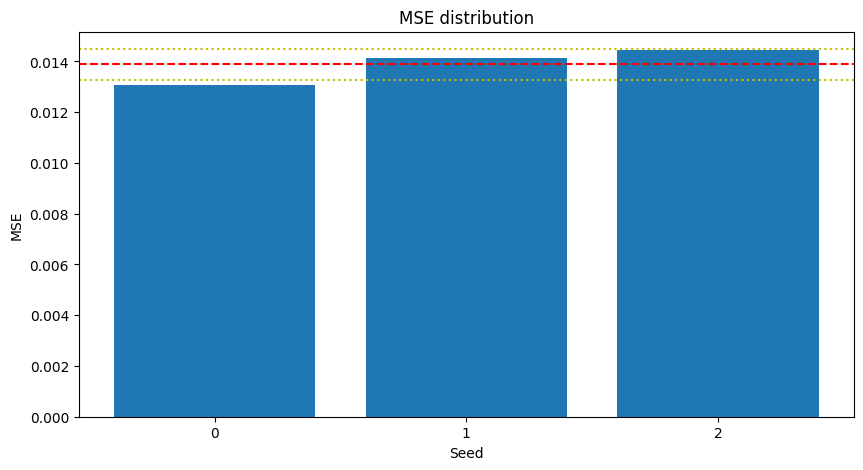

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.11", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_11 = pd.read_excel(excel_file_path)
results_task3_11.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-11.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-11.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.12 50% unsupervised, 50% supervised

In [ ]:
tr, ts, trs, tru = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.50
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru,vs,  ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-12.log')

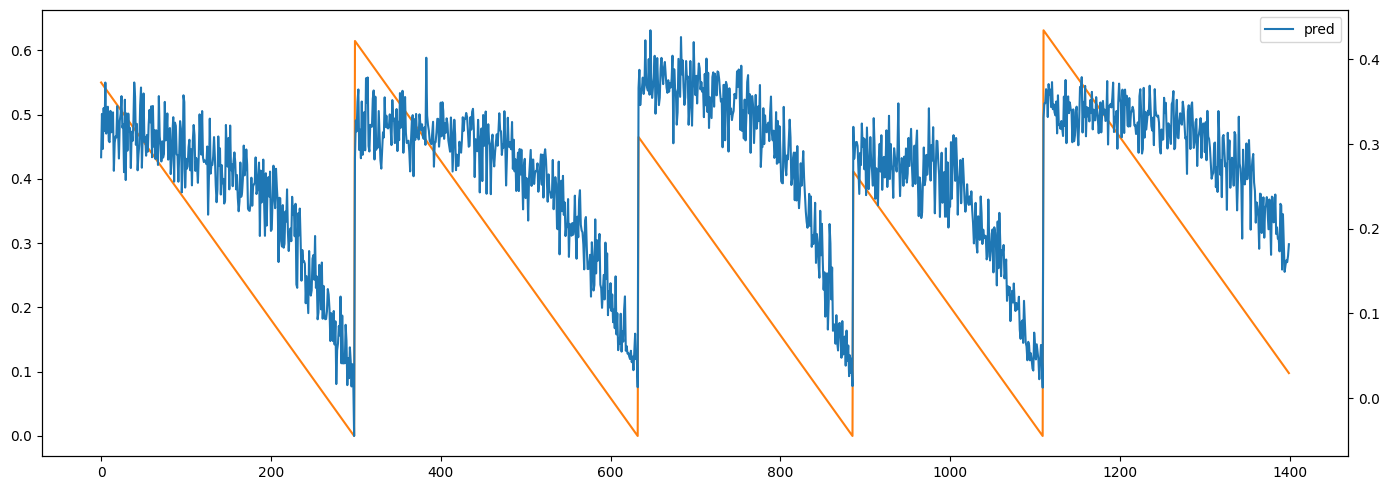

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


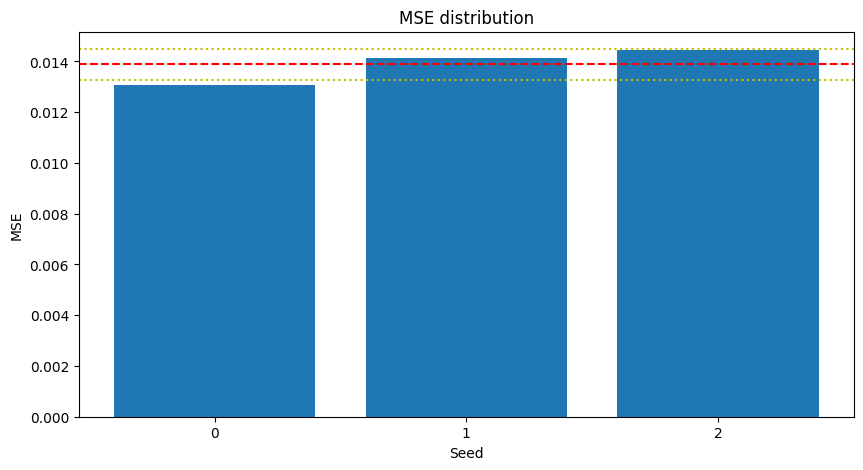

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.12", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_12 = pd.read_excel(excel_file_path)
results_task3_12.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-12.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-12.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.13 50% unsupervised, 25% supervised

In [ ]:
tr, ts, trs, tru, vs= cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.50 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-13.log')

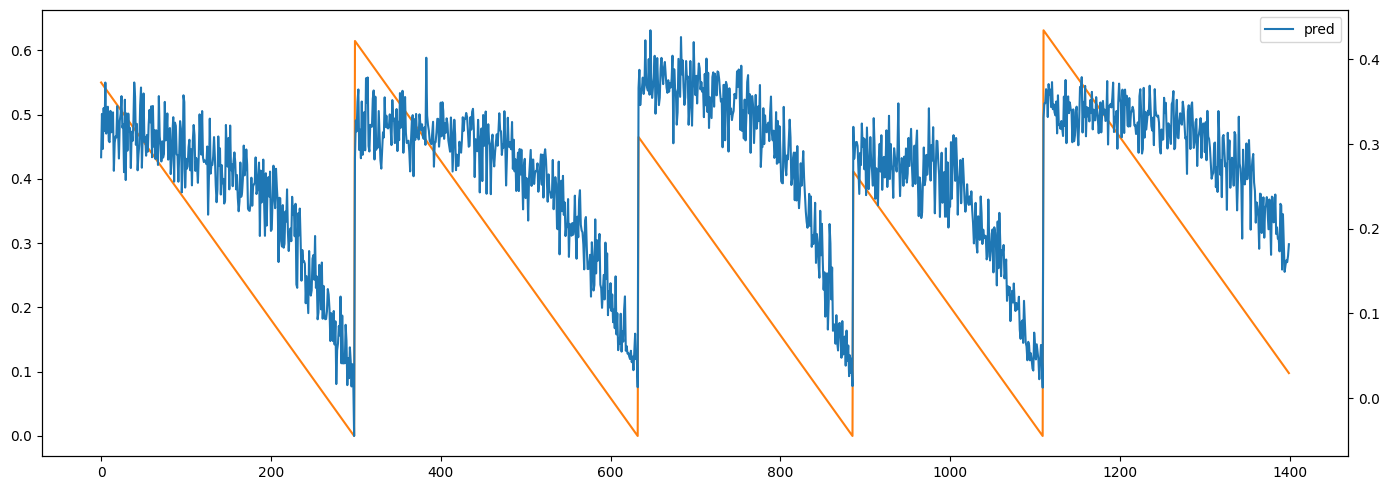

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


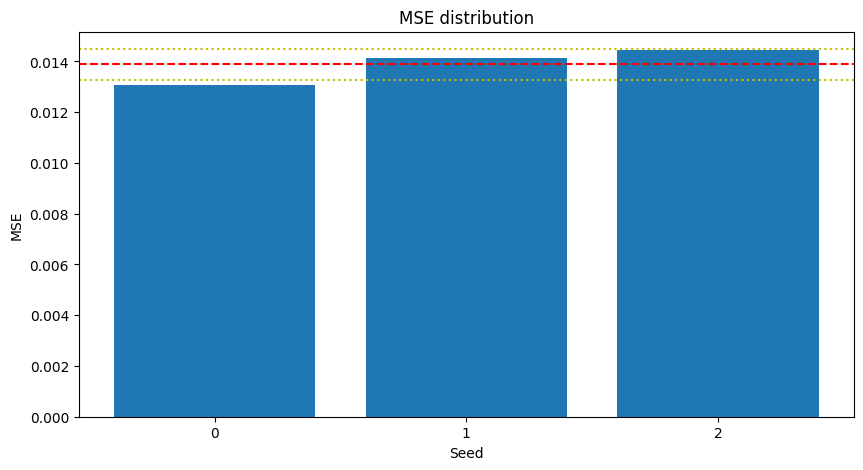

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.13", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_13 = pd.read_excel(excel_file_path)
results_task3_13.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-13.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-13.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.14 25% unsupervised, 75% supervised

In [ ]:
tr, ts, trs, tru,vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.25 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-14.log')

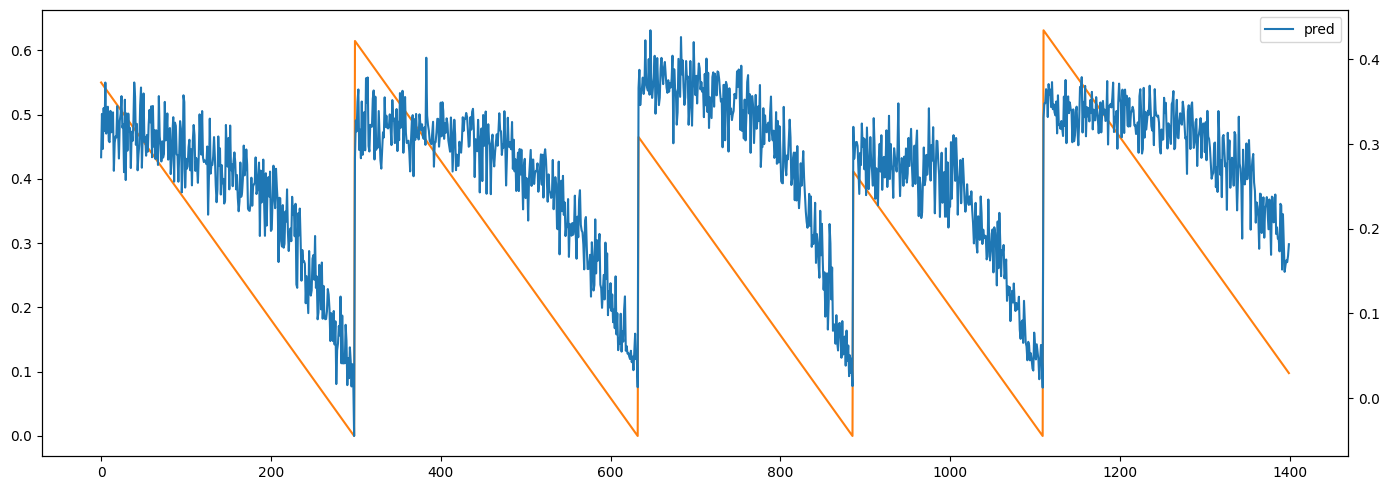

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


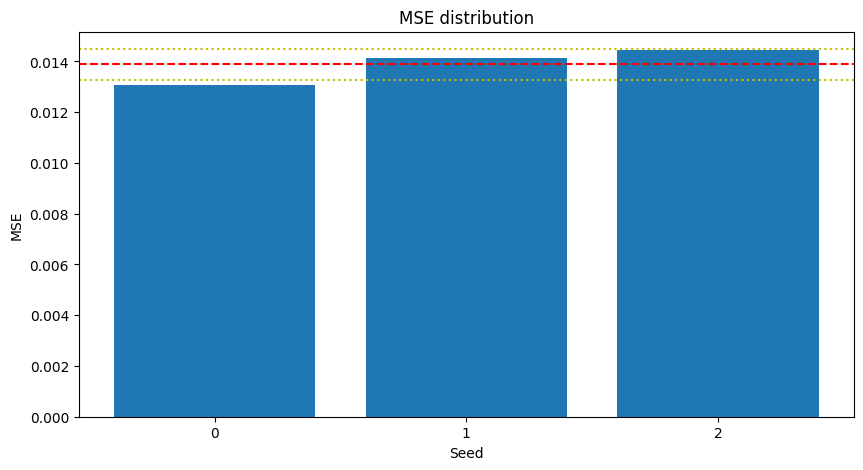

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.14", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_14 = pd.read_excel(excel_file_path)
results_task3_14.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-14.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-14.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.15 25% unsupervised, 50% supervised

In [ ]:
tr, ts, trs, tru, vs= cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.25 
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-15.log')

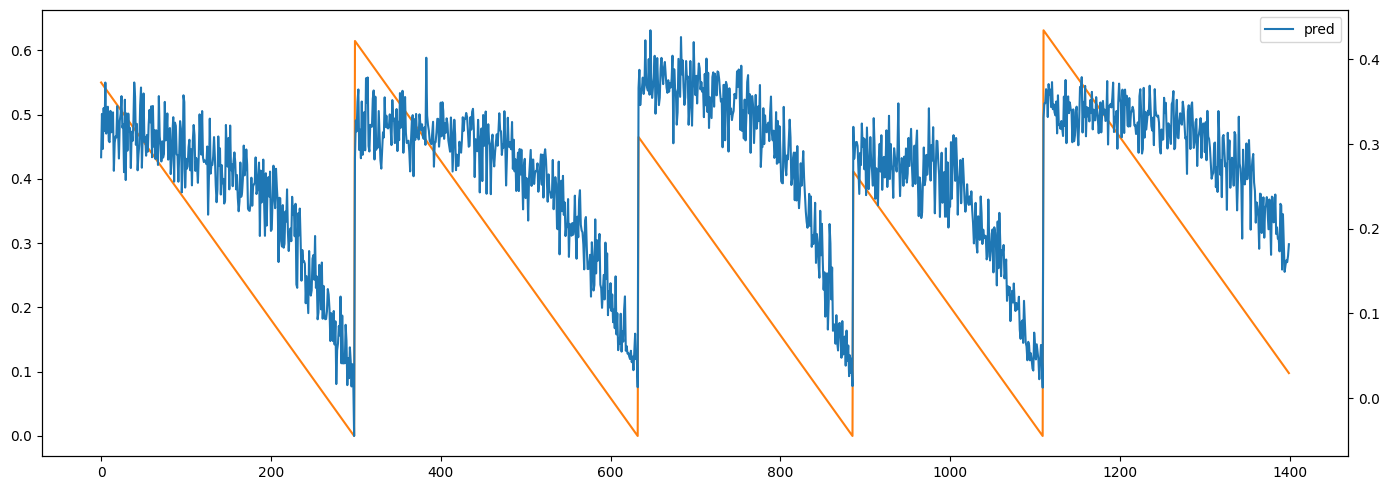

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


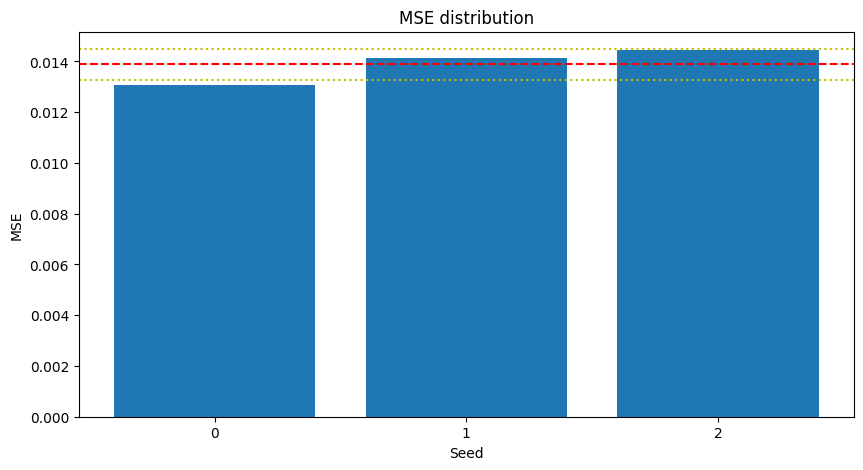

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.15", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_15 = pd.read_excel(excel_file_path)
results_task3_15.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-15.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-15.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

**Results**

##### 3.16 25% unsupervised, 25% supervised

In [ ]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

In [ ]:
ratio_unsup = 0.25 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

SyntaxError: invalid syntax (1174986294.py, line 1)

In [ ]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-16.log')

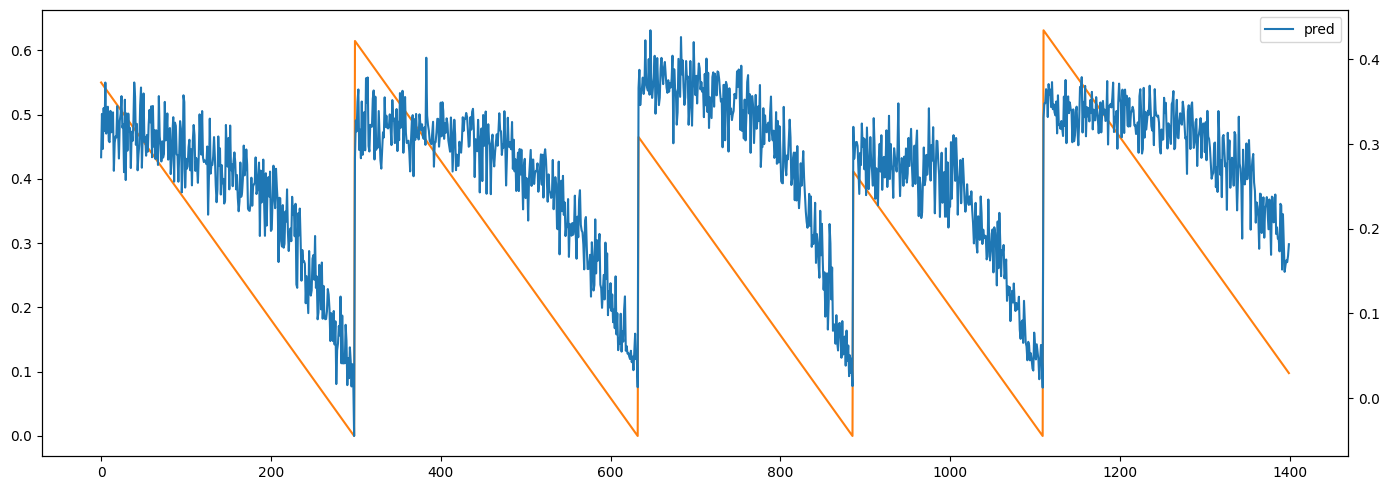

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


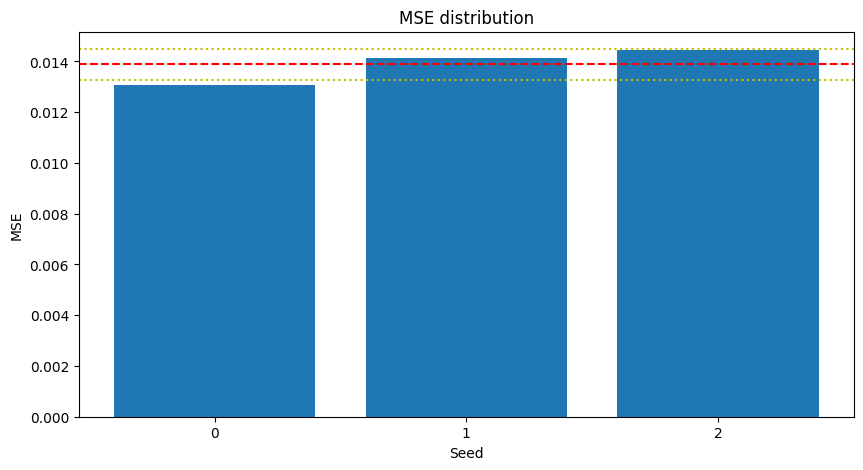

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 3.16", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
results_task3_16 = pd.read_excel(excel_file_path)
results_task3_16.head()

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0  Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1  Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2  Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3  Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4  Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-16.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-3-16.xlsx').head(10)

Seed_0     Seed_1  rul
0  83.656311  36.880489  298
1  81.534294  46.551170  297
2  83.578766  36.409859  296
3  83.470818  36.126854  295
4  84.892036  30.376909  294
5  80.730774  43.942482  293
6  82.561966  37.338112  292
7  84.305626  40.038902  291
8  81.624268  37.496830  290
9  88.007339  41.915588  289

#### Results on Task 3

In [10]:
results_task3 = pd.read_excel('results.xlsx')

results_task3_1= results_task3[results_task3['Task'] == 'Task 3.1']
results_task3_2 = results_task3[results_task3['Task'] == 'Task 3.2']
results_task3_3 = results_task3[results_task3['Task'] == 'Task 3.3']
results_task3_4 = results_task3[results_task3['Task'] == 'Task 3.4']
results_task3_5 = results_task3[results_task3['Task'] == 'Task 3.5']
results_task3_6 = results_task3[results_task3['Task'] == 'Task 3.6']
results_task3_7 = results_task3[results_task3['Task'] == 'Task 3.7']
results_task3_8 = results_task3[results_task3['Task'] == 'Task 3.8']
results_task3_9 = results_task3[results_task3['Task'] == 'Task 3.9']
results_task3_10 = results_task3[results_task3['Task'] == 'Task 3.10']
results_task3_11 = results_task3[results_task3['Task'] == 'Task 3.11']
results_task3_12 = results_task3[results_task3['Task'] == 'Task 3.12']
results_task3_13 = results_task3[results_task3['Task'] == 'Task 3.13']
results_task3_14 = results_task3[results_task3['Task'] == 'Task 3.14']
results_task3_15 = results_task3[results_task3['Task'] == 'Task 3.15']
results_task3_16 = results_task3[results_task3['Task'] == 'Task 3.16']

drop_columns = ['Seed_0', 'Seed_1', 'Seed_2'] 
res_task3 = pd.concat([results_task3_1, results_task3_2, results_task3_3, results_task3_4, results_task3_5, results_task3_6, results_task3_7, results_task3_8, results_task3_9, results_task3_10, results_task3_11, results_task3_12, results_task3_13, results_task3_14, results_task3_15, results_task3_16]).drop(columns=drop_columns)

print(tabulate(res_task3, headers='keys', showindex=False,  tablefmt='psql'))



+--------+--------+-------+
| Task   | Mean   | Std   |
|--------+--------+-------|
+--------+--------+-------+


Comments on the results + choice of the best model needed for task 4

### **Task 4**: Domain Knowledge injection by adding a new regularizer. We want to enforce the RUL being strictly positive

We think that adding a regularizer to enforce the RUL to be strictly positive will have a positive influence on model's performances with only unsupervised data. Indeed inferring **domain knowledge** will enhance the prediction qualiy of the regressor.
As a matter of fact we expect that the following model will achieve better results in comparison with the previous one (that considers only unsupervised data).

Tuning the hyperparameter *gamma* should have a great impact on the results obtained.

In [36]:
#usando unsupervised 100% e gamma = 0.1 -> Media della MSE: 0.0324, Deviazione standard della MSE: 0.0072
#TODO: tuning di paramentro gamma 

In [141]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 149 (unsupervised), 37 (validation), 63 (test)


In [142]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 36746 (unsupervised), 8639 (validation), 15864 (test)


In [143]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)

In [144]:
tru_st = cst.remove_rul(tru_s)

In [148]:
history, predictions = train_task4(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=0.0, beta=1.0, gamma=1.0, logger_file = 'training-4.log')
    

Epoch 1/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0074 - mse: 0.0324 - cst: 0.0073 - positivity_regularizer: 5.7701e-05 - val_loss: 5.0482e-04 - val_mse: 0.0256 - val_cst: 5.0482e-04 - val_positivity_regularizer: 0.0000e+00
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 5.5077e-04 - mse: 0.0290 - cst: 5.5077e-04 - positivity_regularizer: 0.0000e+00 - val_loss: 4.4467e-04 - val_mse: 0.0265 - val_cst: 4.4467e-04 - val_positivity_regularizer: 0.0000e+00
Epoch 3/5
615/615 [==============================] - 2s 3ms/step - loss: 5.3403e-04 - mse: 0.0300 - cst: 5.3403e-04 - positivity_regularizer: 0.0000e+00 - val_loss: 4.8005e-04 - val_mse: 0.0280 - val_cst: 4.8005e-04 - val_positivity_regularizer: 0.0000e+00
Epoch 4/5
615/615 [==============================] - 2s 3ms/step - loss: 5.0617e-04 - mse: 0.0316 - cst: 5.0617e-04 - positivity_regularizer: 0.0000e+00 - val_loss: 4.1107e-04 - val_mse: 0.0290 - val_cst: 4.1107e-04 - val_positivity_regu

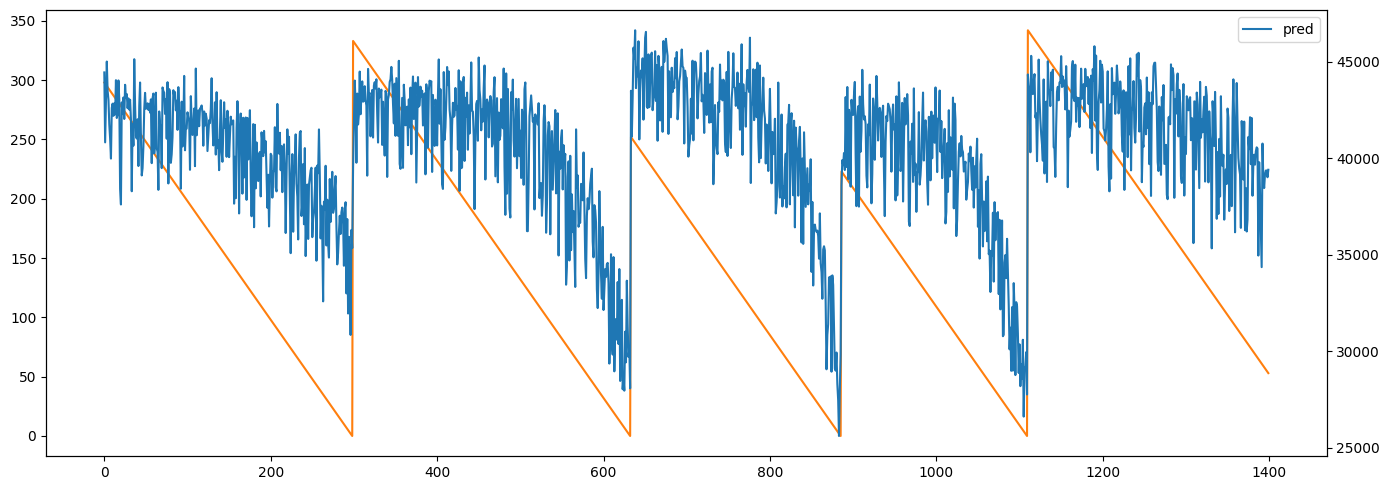

In [149]:
ts_pred = predictions[0]*trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [150]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0399
Standard Deviation of MSE: 0.0013


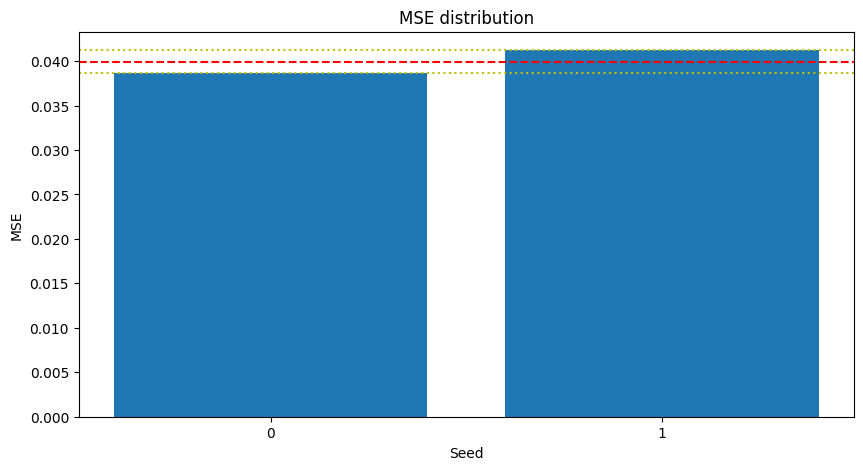

In [136]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [68]:
cst.save_results_to_excel("Task 4", mse_mean, mse_std, mse_seeds, excel_file_path)

In [71]:
results_task4 = pd.read_excel(excel_file_path)
results_task4.head(20)

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0    Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1    Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2    Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3    Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4    Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN
5  Task 3.1.1   4192.381535  3017.902992   7210.284527   1174.478543     NaN
6      Task 5      0.012763     0.000134      0.012629      0.012897     NaN
7      Task 4      0.012763     0.000134      0.012629      0.012897     NaN

In [70]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-4.xlsx')

In [72]:
pd.read_excel('./predictions/predictions-4.xlsx').head(10)

Seed_0      Seed_1  rul
0  212.800339  168.354202  298
1  211.695694  195.554565  297
2  202.830048  158.672928  296
3  236.082596  195.992599  295
4  189.050064  164.798050  294
5  237.321381  212.299042  293
6  202.741974  181.674896  292
7  203.503998  172.735153  291
8  191.168228  172.818176  290
9  214.482147  178.015778  289

#### Results on Task 4

In [11]:
results_task4 = pd.read_excel('results.xlsx')

drop_columns = ['Seed_0', 'Seed_1', 'Seed_2'] # col to drop aggiungere gli altri seed !!  DEFINISCILA IN ALTO DAGLI IMPORT

# tieni solo task 4 e 4
results_task4= results_task4[results_task4['Task'] == 'Task 4'].drop(columns=drop_columns)

print(tabulate(results_task4, headers='keys', showindex= False, tablefmt='psql'))

+--------+-----------+-------------+
| Task   |      Mean |         Std |
|--------+-----------+-------------|
| Task 4 | 0.0127629 | 0.000133823 |
+--------+-----------+-------------+


### **Task 5**: Lagrangian for dinamic weight of the loss function

In fact, the fairness constraint and accuracy are conflicting goals
Satisfying the constraint has in this case higher priority

Introducing a Lagrange multiplier can be considered as a weight that dynamically adjusts the importance of the regularization term, allowing the model to learn its optimal value during training.

In [137]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

Num. machines: 149 (unsupervised), 37 (validation), 63 (test)
Num. samples: 36746 (unsupervised), 8639 (validation), 15864 (test)


In [138]:
history, predictions = train_task5(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-5.log')

Epoch 1/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0346 - mse: 0.0263 - cst: 0.0084 - val_loss: 0.0236 - val_mse: 0.0213 - val_cst: 0.0024
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0196 - mse: 0.0175 - cst: 0.0023 - val_loss: 0.0263 - val_mse: 0.0232 - val_cst: 0.0035
Epoch 3/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0181 - mse: 0.0162 - cst: 0.0024 - val_loss: 0.0167 - val_mse: 0.0153 - val_cst: 0.0020
Epoch 4/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0162 - mse: 0.0148 - cst: 0.0025 - val_loss: 0.0166 - val_mse: 0.0152 - val_cst: 0.0038
Epoch 5/5
496/496 [==============================] - 0s 380us/step
Epoch 1/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0275 - mse: 0.0234 - cst: 0.0042 - val_loss: 0.0205 - val_mse: 0.0188 - val_cst: 0.0019
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0201 - mse: 0.0183 - cst: 0.0023 - val_loss

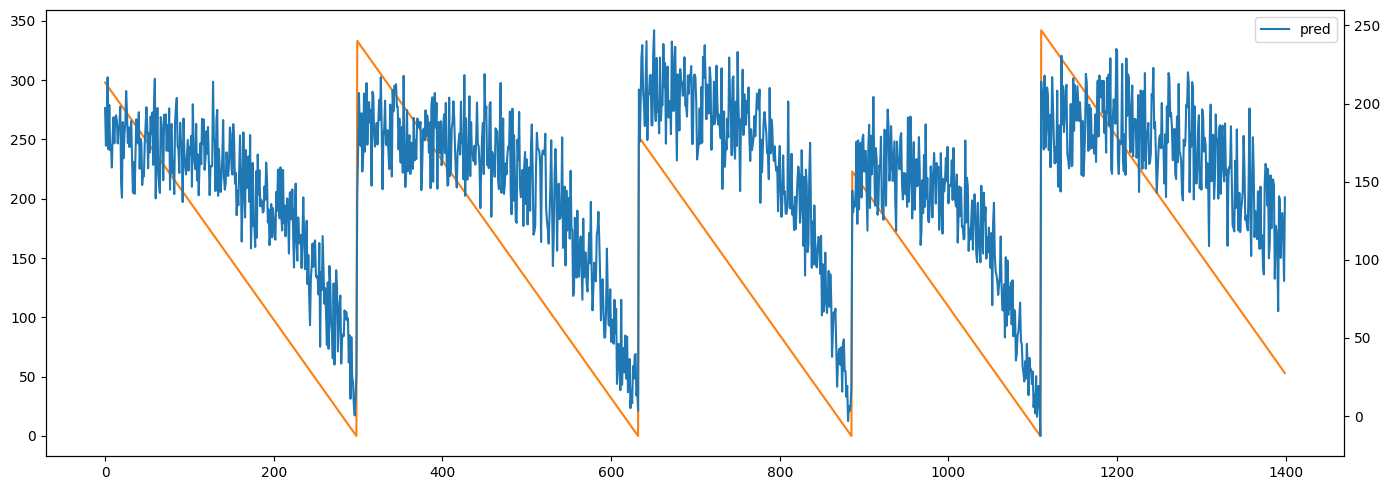

In [139]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [140]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0143
Standard Deviation of MSE: 0.0005


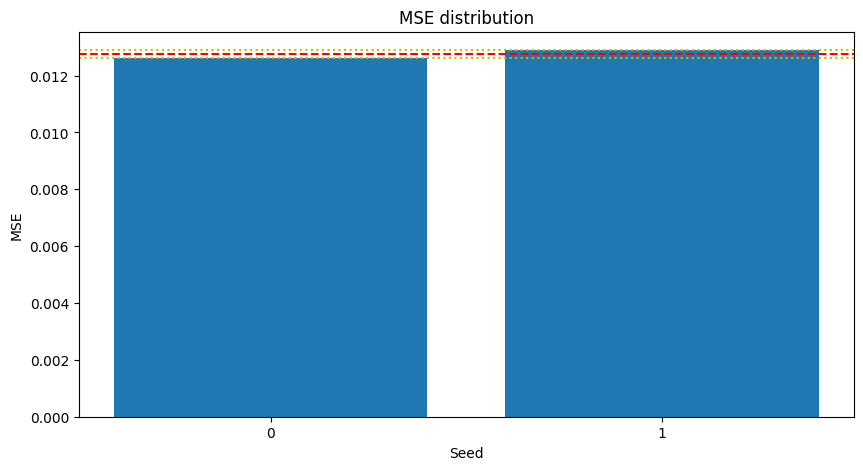

In [61]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [62]:
cst.save_results_to_excel("Task 5", mse_mean, mse_std, mse_seeds, excel_file_path)

In [65]:
results_task5 = pd.read_excel(excel_file_path)
results_task5.head(20)

Task          Mean          Std        Seed_0        Seed_1  Seed_2
0    Task 1.1   4449.200321   388.466231   4060.734090   4837.666551     NaN
1    Task 1.2   4449.200321   388.466231   4060.734090   4837.666551     NaN
2    Task 1.3   5079.337457   571.356063   5650.693520   4507.981395     NaN
3    Task 2.1  18290.628943  6147.148929  12143.480015  24437.777872     NaN
4    Task 2.2  18290.628943  6147.148929  12143.480015  24437.777872     NaN
5  Task 3.1.1   4192.381535  3017.902992   7210.284527   1174.478543     NaN
6      Task 5      0.012763     0.000134      0.012629      0.012897     NaN

In [64]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-5.xlsx')

In [66]:
pd.read_excel('./predictions/predictions-5.xlsx').head(10)

Seed_0      Seed_1  rul
0  212.800339  168.354202  298
1  211.695694  195.554565  297
2  202.830048  158.672928  296
3  236.082596  195.992599  295
4  189.050064  164.798050  294
5  237.321381  212.299042  293
6  202.741974  181.674896  292
7  203.503998  172.735153  291
8  191.168228  172.818176  290
9  214.482147  178.015778  289

#### Results on Task 5

In [12]:
results_task5 = pd.read_excel('results.xlsx')

drop_columns = ['Seed_0', 'Seed_1', 'Seed_2'] # col to drop aggiungere gli altri seed !!  DEFINISCILA IN ALTO DAGLI IMPORT

# tieni solo task 5
results_task5= results_task5[results_task5['Task'] == 'Task 5'].drop(columns=drop_columns)

print(tabulate(results_task5, headers='keys', showindex= False, tablefmt='psql'))

+--------+-----------+-------------+
| Task   |      Mean |         Std |
|--------+-----------+-------------|
| Task 5 | 0.0127629 | 0.000133823 |
+--------+-----------+-------------+


### **Final observations and comments**

In [13]:
results = pd.read_excel('results.xlsx')
results.drop(columns=drop_columns)

print(tabulate(results, headers='keys', showindex= False, tablefmt='psql'))


+------------+---------------+----------------+---------------+---------------+----------+
| Task       |          Mean |            Std |        Seed_0 |        Seed_1 |   Seed_2 |
|------------+---------------+----------------+---------------+---------------+----------|
| Task 1.1   |     0.0128889 |    0.000392717 |     0.0132816 |     0.0124962 |      nan |
| Task 1.2   |  4449.2       |  388.466       |  4060.73      |  4837.67      |      nan |
| Task 1.3   |  5079.34      |  571.356       |  5650.69      |  4507.98      |      nan |
| Task 2.1   | 18290.6       | 6147.15        | 12143.5       | 24437.8       |      nan |
| Task 2.2   | 18290.6       | 6147.15        | 12143.5       | 24437.8       |      nan |
| Task 3.1.1 |  4192.38      | 3017.9         |  7210.28      |  1174.48      |      nan |
| Task 5     |     0.0127629 |    0.000133823 |     0.0126291 |     0.0128968 |      nan |
| Task 4     |     0.0127629 |    0.000133823 |     0.0126291 |     0.0128968 |      nan |

Spiegare quale funziona meglio e perchè.. 
osservazioni finali